# Similarity testing pipeline

-----

##### Imports

In [1]:
from functools import partial

from ariel_experiments.characterize.canonical.core.toolkit import (
    CanonicalToolKit as ctk,
)
from ariel_experiments.characterize.individual import analyze_neighbourhood
from ariel_experiments.utils.initialize import (
    generate_random_population_parallel,
)

from ariel_experiments.characterize.population import (
    # AnalyzedPopulation,
    get_full_analyzed_population,
    derive_numeric_summary,
    derive_uniques,
    derive_min_first_idx,
    derive_max_first_idx,
    get_derived_population_properties
)

from ariel_experiments.characterize.population import (
    derive_matrix_numerics,
    matrix_derive_neighbourhood,
    get_full_analyzed_population,
    derive_numeric_summary
)
from ariel_experiments.gui_vis.gui import (
    IndividualVisualizer,
)
from ariel_experiments.gui_vis.gui_simple import (
    SimpleNavigator,
)

from ariel_experiments.gui_vis.visualize_tree import visualize_tree_from_graph

import seaborn as sns
import numpy as np
import plotly.graph_objects as go

import networkx as nx

from ariel_experiments.gui_vis.view_mujoco import view

import matplotlib.pyplot as plt

objc[60567]: Class GLFWHelper is implemented in both /Users/salomepoulain/projects/ariel-zoo/.venv/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-312-darwin.so (0x13f90fa28) and /Users/salomepoulain/projects/ariel-zoo/.venv/lib/python3.12/site-packages/glfw/libglfw.3.dylib (0x164131bb8). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[60567]: Class GLFWApplicationDelegate is implemented in both /Users/salomepoulain/projects/ariel-zoo/.venv/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-312-darwin.so (0x13f90fa78) and /Users/salomepoulain/projects/ariel-zoo/.venv/lib/python3.12/site-packages/glfw/libglfw.3.dylib (0x164131c08). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[60567]: Class GLFWWindowDelegate is implemented in both /Users/salomepoulain/projects/ariel-zoo/.venv/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-3

##### constants/globals

In [2]:
from rich.console import Console
console = Console()

In [3]:
def plot_two_mujocos(graph1: nx.DiGraph, graph2: nx.DiGraph, name_list: list[str] | None = None):
    img1 = view(graph1, return_img=True)
    img2 = view(graph2, return_img=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

    ax1.imshow(img1)
    if name_list:
        ax1.set_title(name_list[0])
    ax1.axis('off')

    ax2.imshow(img2)
    if name_list:
        ax2.set_title(name_list[1])
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
def plot_matrix_distribution(
    matrix: np.ndarray,
    triangle: str = "upper",
    include_diagonal: bool = False,
    cmap: str = "viridis",
    bins: int = 190,
    figsize: tuple[int, int] = (14, 6),
    title_prefix: str = ""
):
    """Plot matrix heatmap and value distribution side by side."""
    
    # Extract triangle values
    k_offset = 1 if not include_diagonal else 0
    
    if triangle.lower() == "upper":
        values = matrix[np.triu_indices_from(matrix, k=k_offset)]
        mask = np.tril(np.ones_like(matrix, dtype=bool), k=k_offset-1)
        triangle_name = "Upper"
    elif triangle.lower() == "lower":
        values = matrix[np.tril_indices_from(matrix, k=-k_offset)]
        mask = np.triu(np.ones_like(matrix, dtype=bool), k=-k_offset+1)
        triangle_name = "Lower"
    else:
        raise ValueError("triangle must be 'upper' or 'lower'")
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot heatmap
    sns.heatmap(
        matrix,
        mask=mask,
        ax=axes[0],
        cmap=cmap,
        square=True,
        cbar_kws={'label': 'Value'}
    )
    diag_text = "with" if include_diagonal else "without"
    axes[0].set_title(f'{title_prefix}{triangle_name} Triangle Heatmap\n({diag_text} diagonal)')
    axes[1].hist(values, bins=bins, alpha=0.7, edgecolor='black', color='steelblue')
    axes[1].axvline(np.mean(values), color='black', linestyle='--', 
                    linewidth=1, label=f'Mean: {np.mean(values):.3f}')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{title_prefix}Value Distribution (n={len(values)})')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Add statistics text
    stats_text = (
        f'Min: {np.min(values):.3f}\n'
        f'Max: {np.max(values):.3f}\n'
        f'Std: {np.std(values):.3f}'
    )
    axes[1].text(0.98, 0.97, stats_text,
                transform=axes[1].transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=9)
    
    plt.tight_layout()
    return fig, axes


hyperparams

In [5]:
population_size = 1000
population = generate_random_population_parallel(population_size)

Output()

##### Compute

In [6]:
collection_strategy = ctk.CollectionStrategy.NEIGHBOURHOODS

radius_strategy = ctk.RadiusStrategy.TREE_GLOBAL
max_tree_radius = 3

missing_data_mode = ctk.MissingDataMode.TREAT_AS_ZERO

tanimoto_mode = ctk.TanimotoMode.COUNTS
weighting_mode = ctk.WeightingMode.LINEAR


softmax_beta = 1
power_mean_p = 2


similarity_config = ctk.SimilarityConfig(
    collection_strategy=collection_strategy,
    radius_strategy=radius_strategy,
    weighting_mode=weighting_mode,
    max_tree_radius=max_tree_radius,
    missing_data_mode=missing_data_mode,
    tanimoto_mode=tanimoto_mode,
    softmax_beta=softmax_beta,
    power_mean_p=power_mean_p,
)

In [7]:
analyzed_population = get_full_analyzed_population(
    population,
    analyzers=[
        partial(analyze_neighbourhood, config=similarity_config),
    ],
    derivers=[],
    n_jobs=-1, # fastest
    hide_tracker=True
)
matrix_result = matrix_derive_neighbourhood(
    analyzed_population.raw,
    config=similarity_config,
    symmetric=True,
    n_jobs=-1,
    hide_tracker=False
)

analyzed_population.derived.update(matrix_result)

Computing neighbourhood:   0%|          | 0/100 [00:00<?, ?batch/s]

In [8]:
analyzed_population.show_tree()

AnalyzedPopulation — props=1 derived_keys=2
├── raw
│   └── neighbourhood: len=1000, type=dict
└── derived
    ├── neighbourhood
    │   └── (no derived)
    └── similarity_matrix
        └── full

In [9]:
matrix = analyzed_population.derived["similarity_matrix"]['full']
np.fill_diagonal(matrix, 0)

In [10]:
# matrix_normalized = (matrix - matrix.min()) / (matrix.max() - matrix.min()) * 100
# matrix = matrix_normalized

In [11]:
upper_triu_idx = np.triu_indices_from(matrix, k=1)
vals = matrix[upper_triu_idx]

-----

### Results

##### Quick overview

Mean: 0.231
Median: 0.235
Min: 0.016
Max: 0.350
Std: 0.045

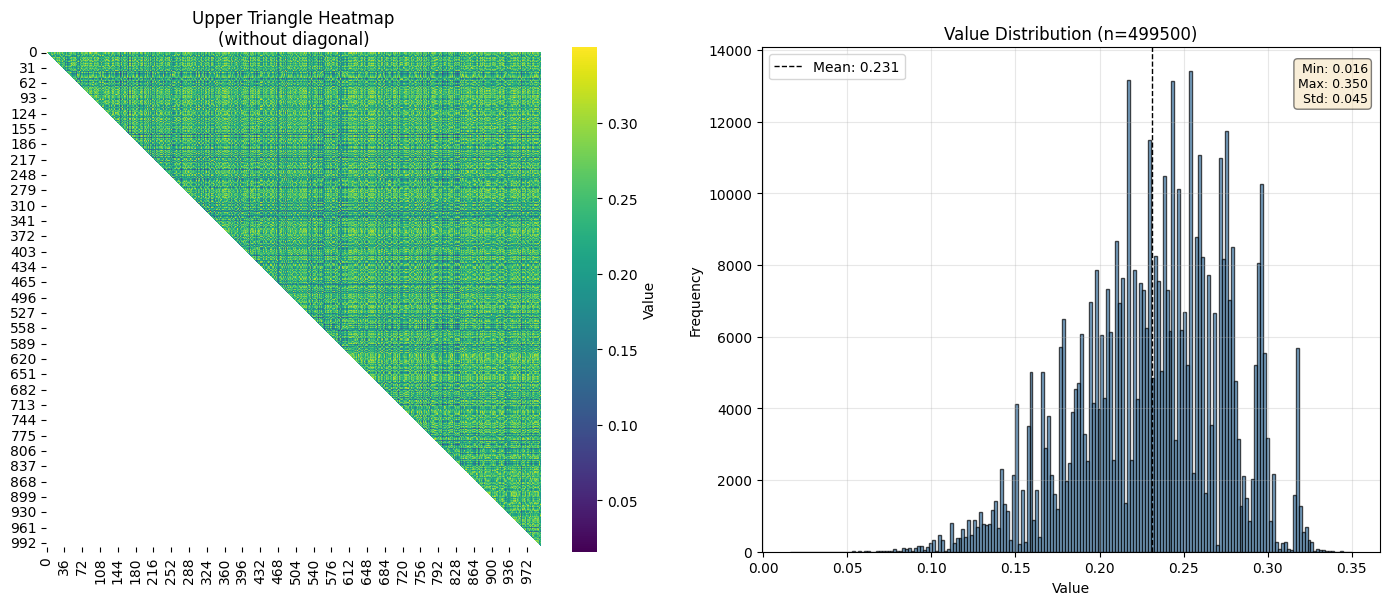

In [12]:
console.print(f"Mean: {np.mean(vals):.3f}\nMedian: {np.median(vals):.3f}\nMin: {np.min(vals):.3f}\nMax: {np.max(vals):.3f}\nStd: {np.std(vals):.3f}")

fig, axes = plot_matrix_distribution(matrix)
plt.show()

##### Highest similarity-pairs

In [13]:
N = 20
if vals.size == 0:
    top = []
else:
    k = min(N, vals.size)
    sel = np.argpartition(-vals, k)[:k]               # top k (unsorted)
    sel = sel[np.argsort(-vals[sel])]                   # sorted desc
    rows = upper_triu_idx[0][sel]
    cols = upper_triu_idx[1][sel]
    top = list(zip(rows.tolist(), cols.tolist(), vals[sel].tolist()))

# top is a list of (row, col, value) tuples sorted by value desc
console.print(top)

iterator = 0

[
    (528, 771, 0.3499999940395355),
    (461, 583, 0.3449999988079071),
    (45, 433, 0.3440000116825104),
    (178, 929, 0.3440000116825104),
    (281, 844, 0.3440000116825104),
    (114, 698, 0.3440000116825104),
    (51, 627, 0.3440000116825104),
    (347, 514, 0.3440000116825104),
    (152, 338, 0.3440000116825104),
    (62, 255, 0.34299999475479126),
    (310, 988, 0.34299999475479126),
    (100, 767, 0.34299999475479126),
    (408, 495, 0.34200000762939453),
    (224, 519, 0.34200000762939453),
    (278, 614, 0.34200000762939453),
    (260, 815, 0.34200000762939453),
    (600, 779, 0.34200000762939453),
    (242, 497, 0.3409999907016754),
    (311, 594, 0.3400000035762787),
    (299, 375, 0.3400000035762787)
]

keep pressing this notebook cell to iterate over the robots

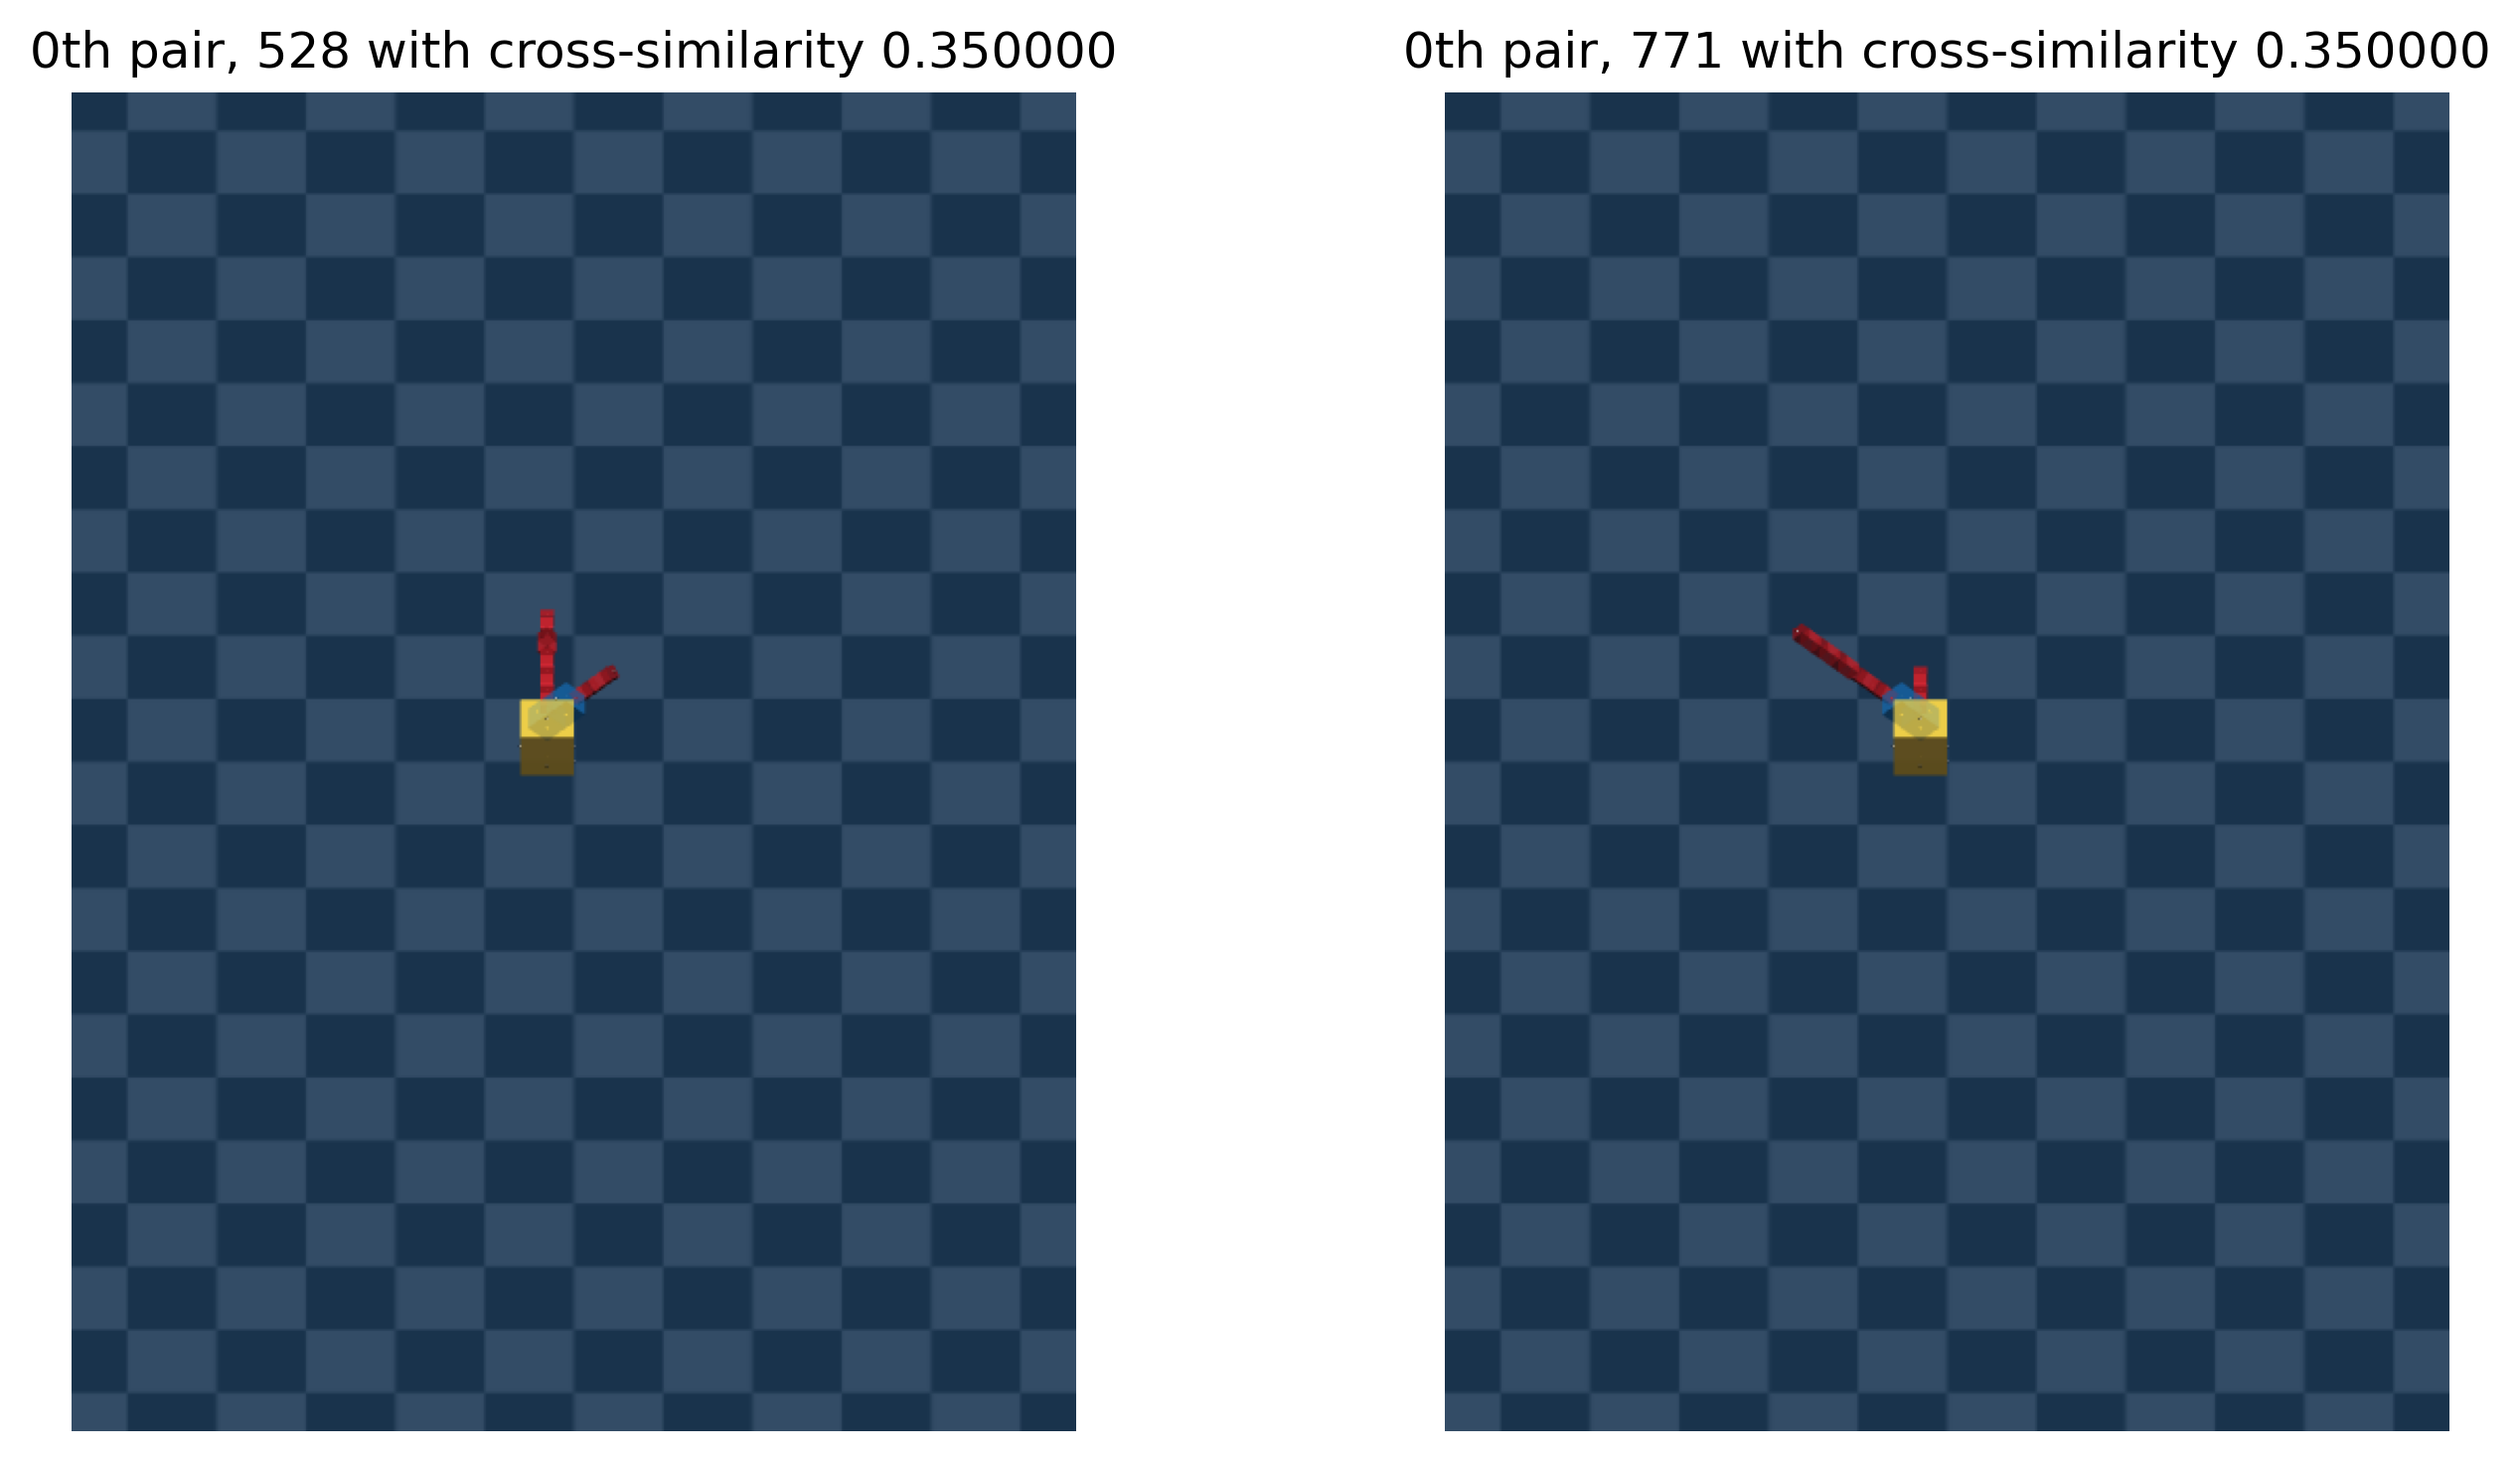

SimilarityResults(
    tree_hash_dicts=(
        {
            0: ['C', 'B', 'H', 'H', 'H', 'H', 'H', 'B', 'H', 'H'],
            1: [
                'C[r(B1)]',
                'C[r(B1[t(B)]H1)]',
                'BH1H',
                'HHH',
                'HHH3',
                'HH3H3',
                'HH3',
                'B[l(BH1)]',
                'BH1H2',
                'HH2'
            ],
            2: [
                'C[r(B1[t(B)]H1)]',
                'C[r(B1[t(BH3)]H1H)]',
                'C[r(B1[t(B)]H1HH)]',
                'BH1HHH3',
                'HHHH3H3',
                'HHH3H3',
                'HH3H3',
                'C[r(B1[t(BH3H2)]H1)]',
                'B[l(BH1H2)]',
                'BH1H2'
            ],
            3: [
                'C[r(B1[t(BH3)]H1H)]',
                'C[r(B1[t(BH3H2)]H1HH)]',
                'C[r(B1[t(BH3)]H1HHH3)]',
                'C[r(B1[t(B)]H1HHH3H3)]',
                'BH1HHH3H3',
                'HHHH3H3',
                'HHH3H3',
                'C[r(B1[t(BH3H2)]H1H)]',
                'C[r(B1[t(BH3H2)]H1)]',
                'B[l(BH1H2)]'
            ]
        },
        {
            0: ['C', 'B', 'H', 'H', 'B', 'H', 'H', 'H', 'H', 'H'],
            1: ['C[r(B1)]', 'C[r(B1[l(B)]H3)]', 'BH3H', 'HH', 'B[l(BH1)]', 'BH1H', 'HHH3', 'HH3H', 'HHH2', 'HH2'],
            2: [
                'C[r(B1[l(B)]H3)]',
                'C[r(B1[l(BH1)]H3H)]',
                'C[r(B1[l(B)]H3H)]',
                'BH3H',
                'C[r(B1[l(BH1H)]H3)]',
                'B[l(BH1HH3)]',
                'BH1HH3H',
                'HHH3HH2',
                'HH3HH2',
                'HHH2'
            ],
            3: [
                'C[r(B1[l(BH1)]H3H)]',
                'C[r(B1[l(BH1H)]H3H)]',
                'C[r(B1[l(BH1)]H3H)]',
                'C[r(B1[l(B)]H3H)]',
                'C[r(B1[l(BH1HH3)]H3H)]',
                'C[r(B1[l(BH1HH3H)]H3)]',
                'B[l(BH1HH3HH2)]',
                'BH1HH3HH2',
                'HHH3HH2',
                'HH3HH2'
            ]
        }
    ),
    similarity_value=0.34960294939005054,
    tanimoto_dict={0: 1.0, 1: 0.3333333333333333, 2: 0.0, 3: 0.0},
    selected_radii=[0, 1, 2, 3],
    obtained_weights=[1.0, 2.0, 3.0, 4.0]
)

In [14]:
node1 = ctk.from_graph(population[top[int(iterator)][0]]).canonicalize()
node2 = ctk.from_graph(population[top[int(iterator)][1]]).canonicalize()

plot_two_mujocos(
    node1.to_graph(),
    node2.to_graph(),
    [f"{iterator}th pair, {top[int(iterator)][0]} with cross-similarity {[top[int(iterator)][2]][0]:2f}", f"{iterator}th pair, {top[int(iterator)][1]} with cross-similarity {[top[int(iterator)][2]][0]:2f}"]
)

results = ctk.calculate_similarity(node1, node2, config=similarity_config, return_all=True)
console.print(results)

iterator = (iterator + 1) % N

##### Lowest similarity-pairs

In [15]:
N = 20

if vals.size == 0:
    bottom = []
else:
    k = min(N, vals.size)
    sel = np.argpartition(vals, k)[:k]                # bottom k (unsorted)
    sel = sel[np.argsort(vals[sel])]                    # sorted asc
    rows = upper_triu_idx[0][sel]
    cols = upper_triu_idx[1][sel]
    bottom = list(zip(rows.tolist(), cols.tolist(), vals[sel].tolist()))

# bottom is a list of (row, col, value) tuples sorted by value asc (lowest first)
console.print(bottom)
iterator = 0

[
    (298, 897, 0.01600000075995922),
    (550, 897, 0.032999999821186066),
    (172, 897, 0.032999999821186066),
    (149, 298, 0.032999999821186066),
    (298, 801, 0.03700000047683716),
    (237, 897, 0.0430000014603138),
    (166, 897, 0.04500000178813934),
    (298, 994, 0.04500000178813934),
    (298, 523, 0.04500000178813934),
    (298, 842, 0.04699999839067459),
    (298, 760, 0.04699999839067459),
    (793, 897, 0.04699999839067459),
    (712, 897, 0.04699999839067459),
    (454, 897, 0.04899999871850014),
    (38, 897, 0.05000000074505806),
    (558, 897, 0.05000000074505806),
    (298, 332, 0.05000000074505806),
    (850, 897, 0.05000000074505806),
    (485, 897, 0.05000000074505806),
    (298, 562, 0.05299999937415123)
]

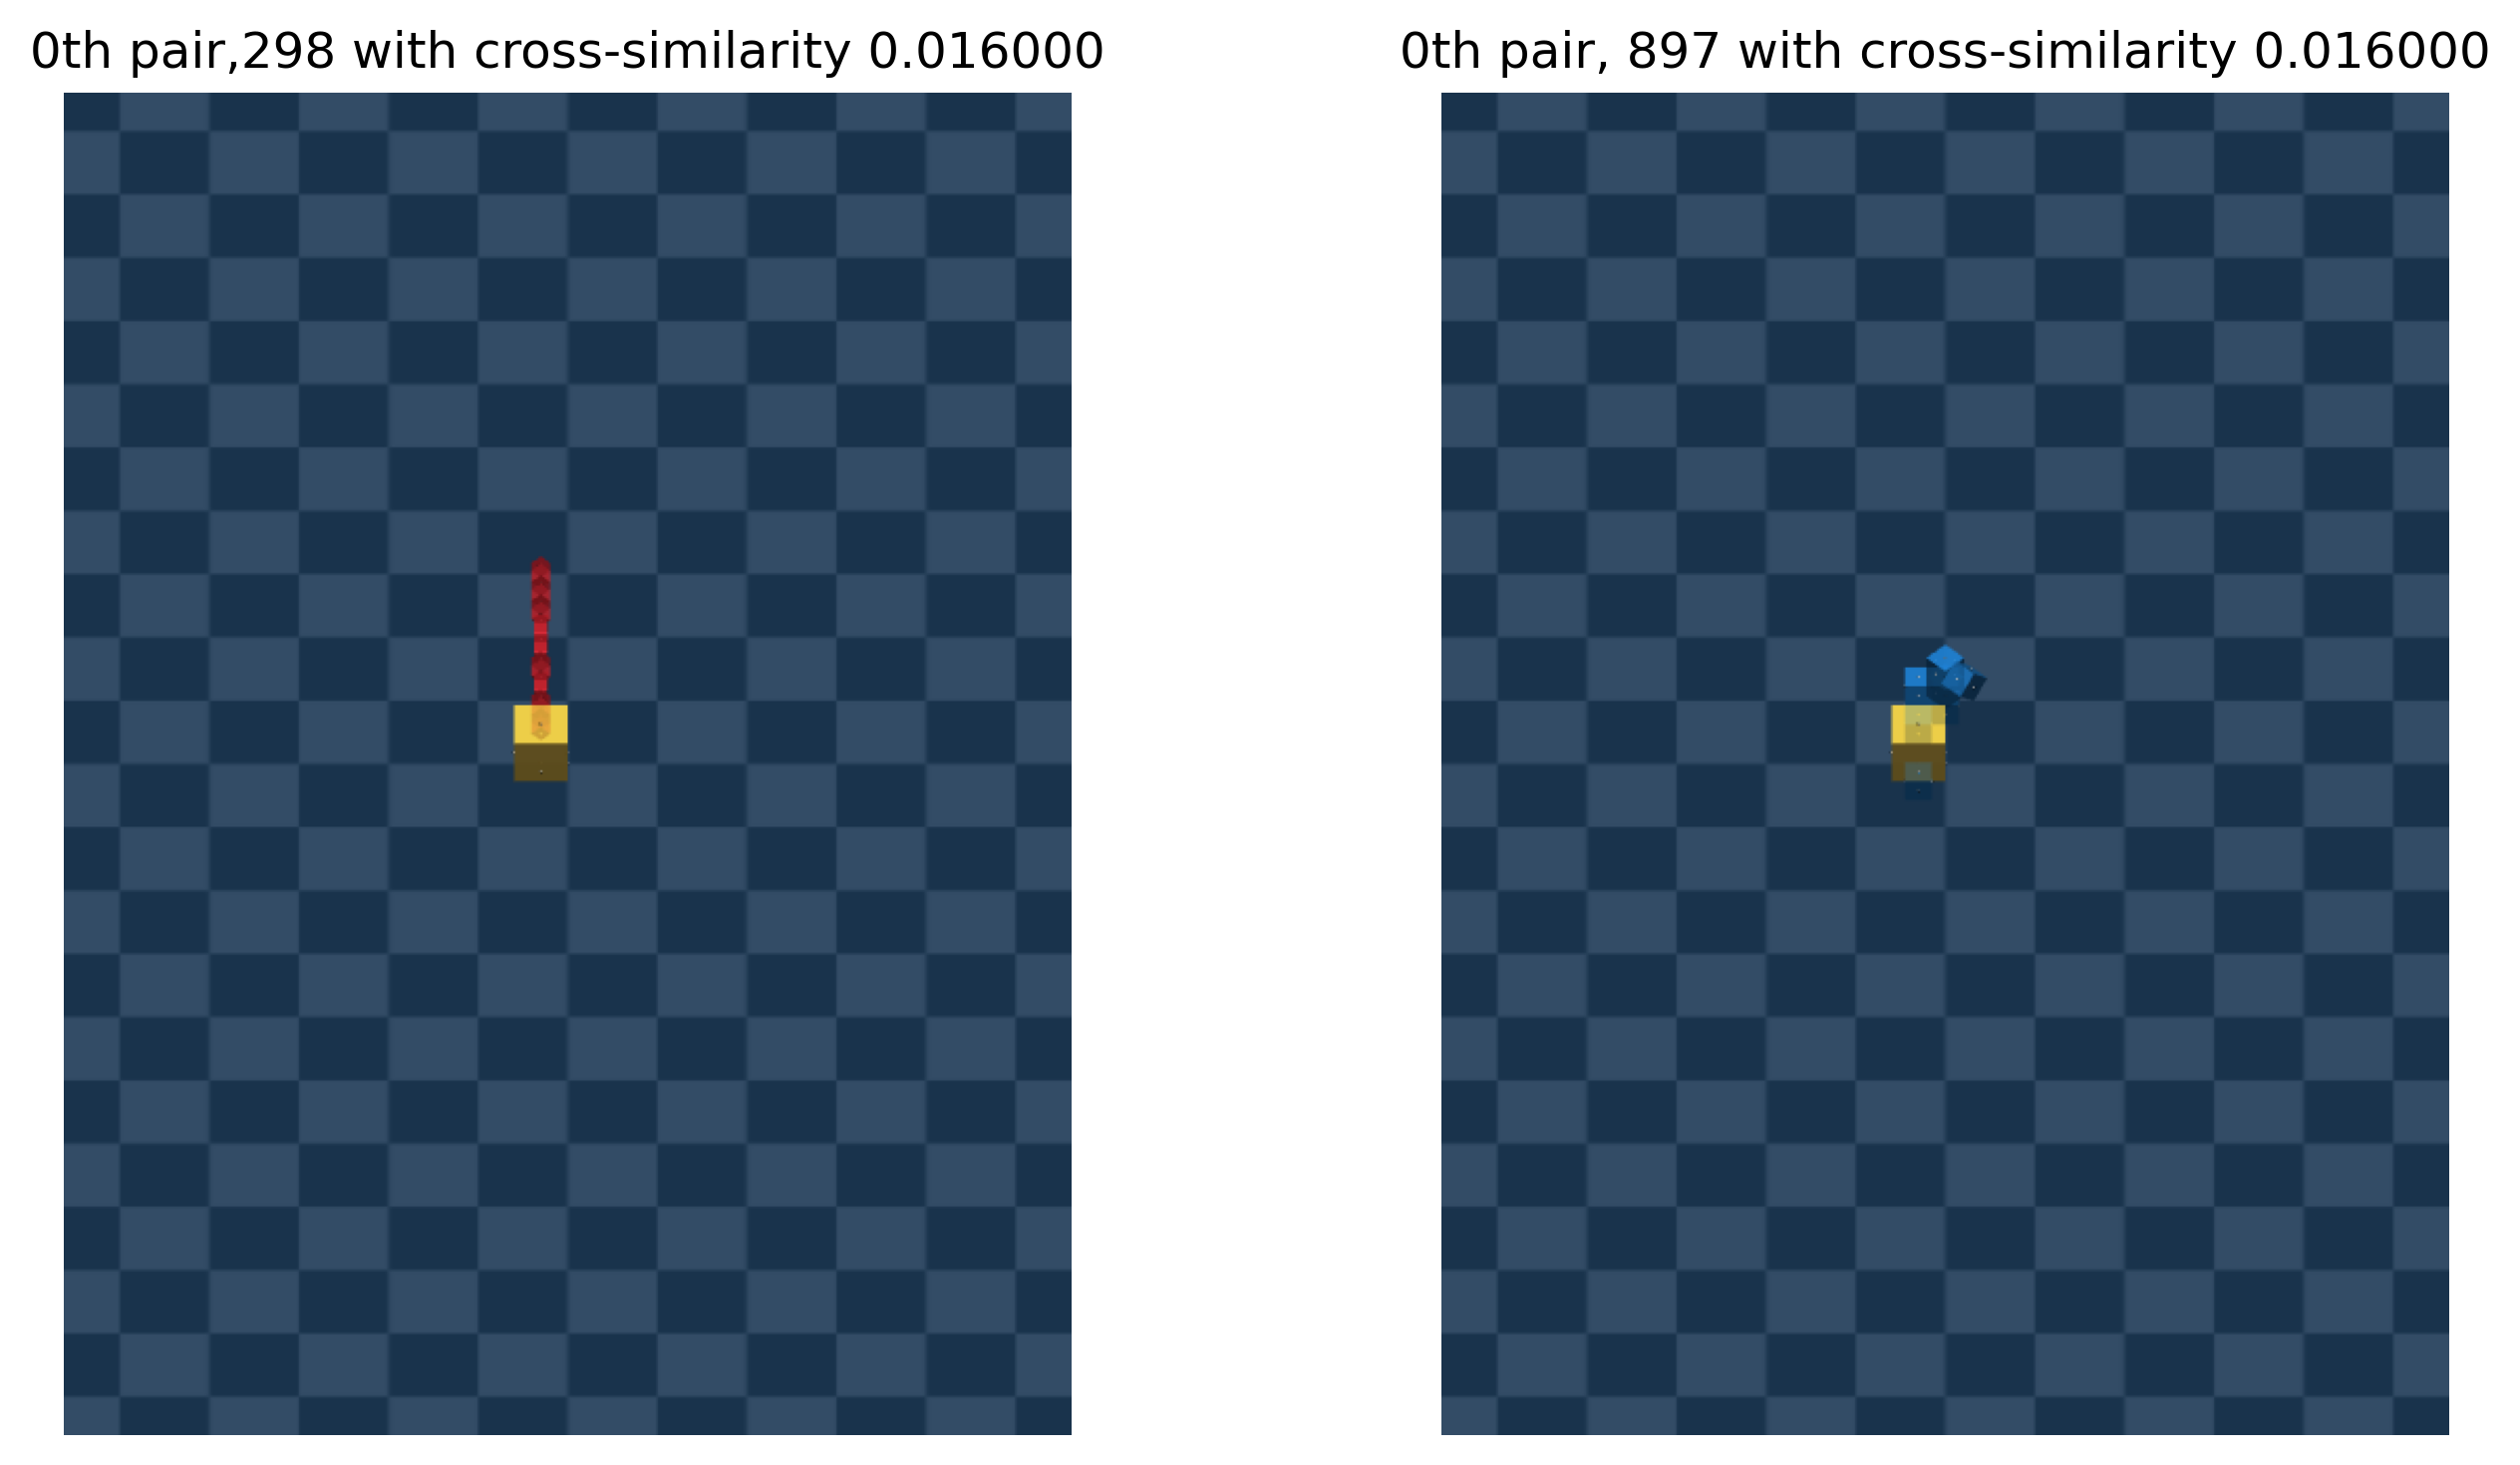

SimilarityResults(
    tree_hash_dicts=(
        {
            0: ['C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
            1: ['C[r(H3)]', 'C[r(H3H)]', 'HHH1', 'HH1H3', 'HH3H3', 'HH3H', 'HHH3', 'HH3H2', 'HH2H', 'HH'],
            2: [
                'C[r(H3H)]',
                'C[r(H3HH1)]',
                'C[r(H3HH1H3)]',
                'HHH1H3H3',
                'HH1H3H3H',
                'HH3H3HH3',
                'HH3HH3H2',
                'HHH3H2H',
                'HH3H2H',
                'HH2H'
            ],
            3: [
                'C[r(H3HH1)]',
                'C[r(H3HH1H3)]',
                'C[r(H3HH1H3H3)]',
                'C[r(H3HH1H3H3H)]',
                'HHH1H3H3HH3',
                'HH1H3H3HH3H2',
                'HH3H3HH3H2H',
                'HH3HH3H2H',
                'HHH3H2H',
                'HH3H2H'
            ]
        },
        {
            0: ['C', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
            1: [
                'C[rl(B)]',
                'C[r(BB)]',
                'BB[rt(B)]',
                'B[l(B[r(B)b(B1)])]',
                'B[l(B)]',
                'B[l(B1)]',
                'B[l(B[t(B)])]',
                'B[l(B[r(B1)])]',
                'B[l(B1[t(B1)])]',
                'B[l(B1)]',
                'C[r(B)]'
            ],
            2: [
                'C[r(B)l(BB)]',
                'C[l(B)r(BB[rt(B)])]',
                'C[r(BB[r(B[l(B)t(B1)])t(B[r(B)])])]',
                'BB[t(B)r(B[l(B)t(B1)])]',
                'B[l(B[r(B)b(B1)])]',
                'B[l(B[r(B)b(B1)])]',
                'BB[r(B)t(B[r(B[l(B1)])])]',
                'B[l(B[t(B[b(B1[r(B1)])])])]',
                'B[l(B[r(B1[b(B1)])])]',
                'B[l(B1[t(B1)])]',
                'C[rl(B)]'
            ],
            3: [
                'C[l(B)r(BB[rt(B)])]',
                'C[l(B)r(BB[r(B[l(B)t(B1)])t(B[r(B)])])]',
                'C[l(B)r(BB[r(B[l(B)t(B1)])t(B[r(B[l(B1)])])])]',
                'C[r(BB[r(B[l(B)t(B1)])t(B[r(B)])])]',
                'BB[t(B)r(B[l(B)t(B1)])]',
                'BB[t(B)r(B[l(B)t(B1)])]',
                'C[r(BB[r(B[l(B)t(B1)])t(B[r(B[l(B1[t(B1)])])])])]',
                'BB[r(B)t(B[r(B[l(B1[t(B1)])])])]',
                'B[l(B[t(B[b(B1[r(B1)])])])]',
                'B[l(B[r(B1[b(B1)])])]',
                'C[l(B)r(BB)]'
            ]
        }
    ),
    similarity_value=0.0158113883008419,
    tanimoto_dict={0: 0.05, 1: 0.0, 2: 0.0, 3: 0.0},
    selected_radii=[0, 1, 2, 3],
    obtained_weights=[1.0, 2.0, 3.0, 4.0]
)

In [16]:
node1 = ctk.from_graph(population[bottom[int(iterator)][0]]).canonicalize()
node2 = ctk.from_graph(population[bottom[int(iterator)][1]]).canonicalize()

plot_two_mujocos(
    node1.to_graph(),
    node2.to_graph(),
    [f"{iterator}th pair,{bottom[int(iterator)][0]} with cross-similarity {[bottom[int(iterator)][2]][0]:2f}", f"{iterator}th pair, {bottom[int(iterator)][1]} with cross-similarity {[bottom[int(iterator)][2]][0]:2f}"]
)

results = ctk.calculate_similarity(node1, node2, config=similarity_config, return_all=True)
console.print(results)

iterator = (iterator + 1) % N

-----

Fitness preperation

In [17]:
fitness_array = (matrix.sum(axis=0) - 1) / len(population)
population_fitness = {'diversity_fitness' : fitness_array}
analyzed_population.raw.update(population_fitness)

deriver_list = [
    derive_numeric_summary,
    derive_uniques,
    derive_min_first_idx,
    derive_max_first_idx,
]

new_derived = get_derived_population_properties(
    population_fitness,
    deriver_list,
    hide_tracker=True
)

matrix_stats = derive_matrix_numerics(
    analyzed_population.derived,
    key="similarity_matrix"
)

analyzed_population.derived.update(matrix_stats)
analyzed_population.derived.update(new_derived)

analyzed_population.show_tree()

AnalyzedPopulation — props=2 derived_keys=3
├── raw
│   ├── diversity_fitness: len=1000, type=float32
│   └── neighbourhood: len=1000, type=dict
└── derived
    ├── diversity_fitness
    │   ├── max_first_idx
    │   ├── min_first_idx
    │   ├── numeric_stats
    │   └── uniques
    ├── neighbourhood
    │   └── (no derived)
    └── similarity_matrix
        ├── full
        ├── matrix_max_first_idx
        ├── matrix_min_first_idx
        └── matrix_stats

##### Most similar and diverse Individuals (as fitness)

In [18]:
tracker = 0

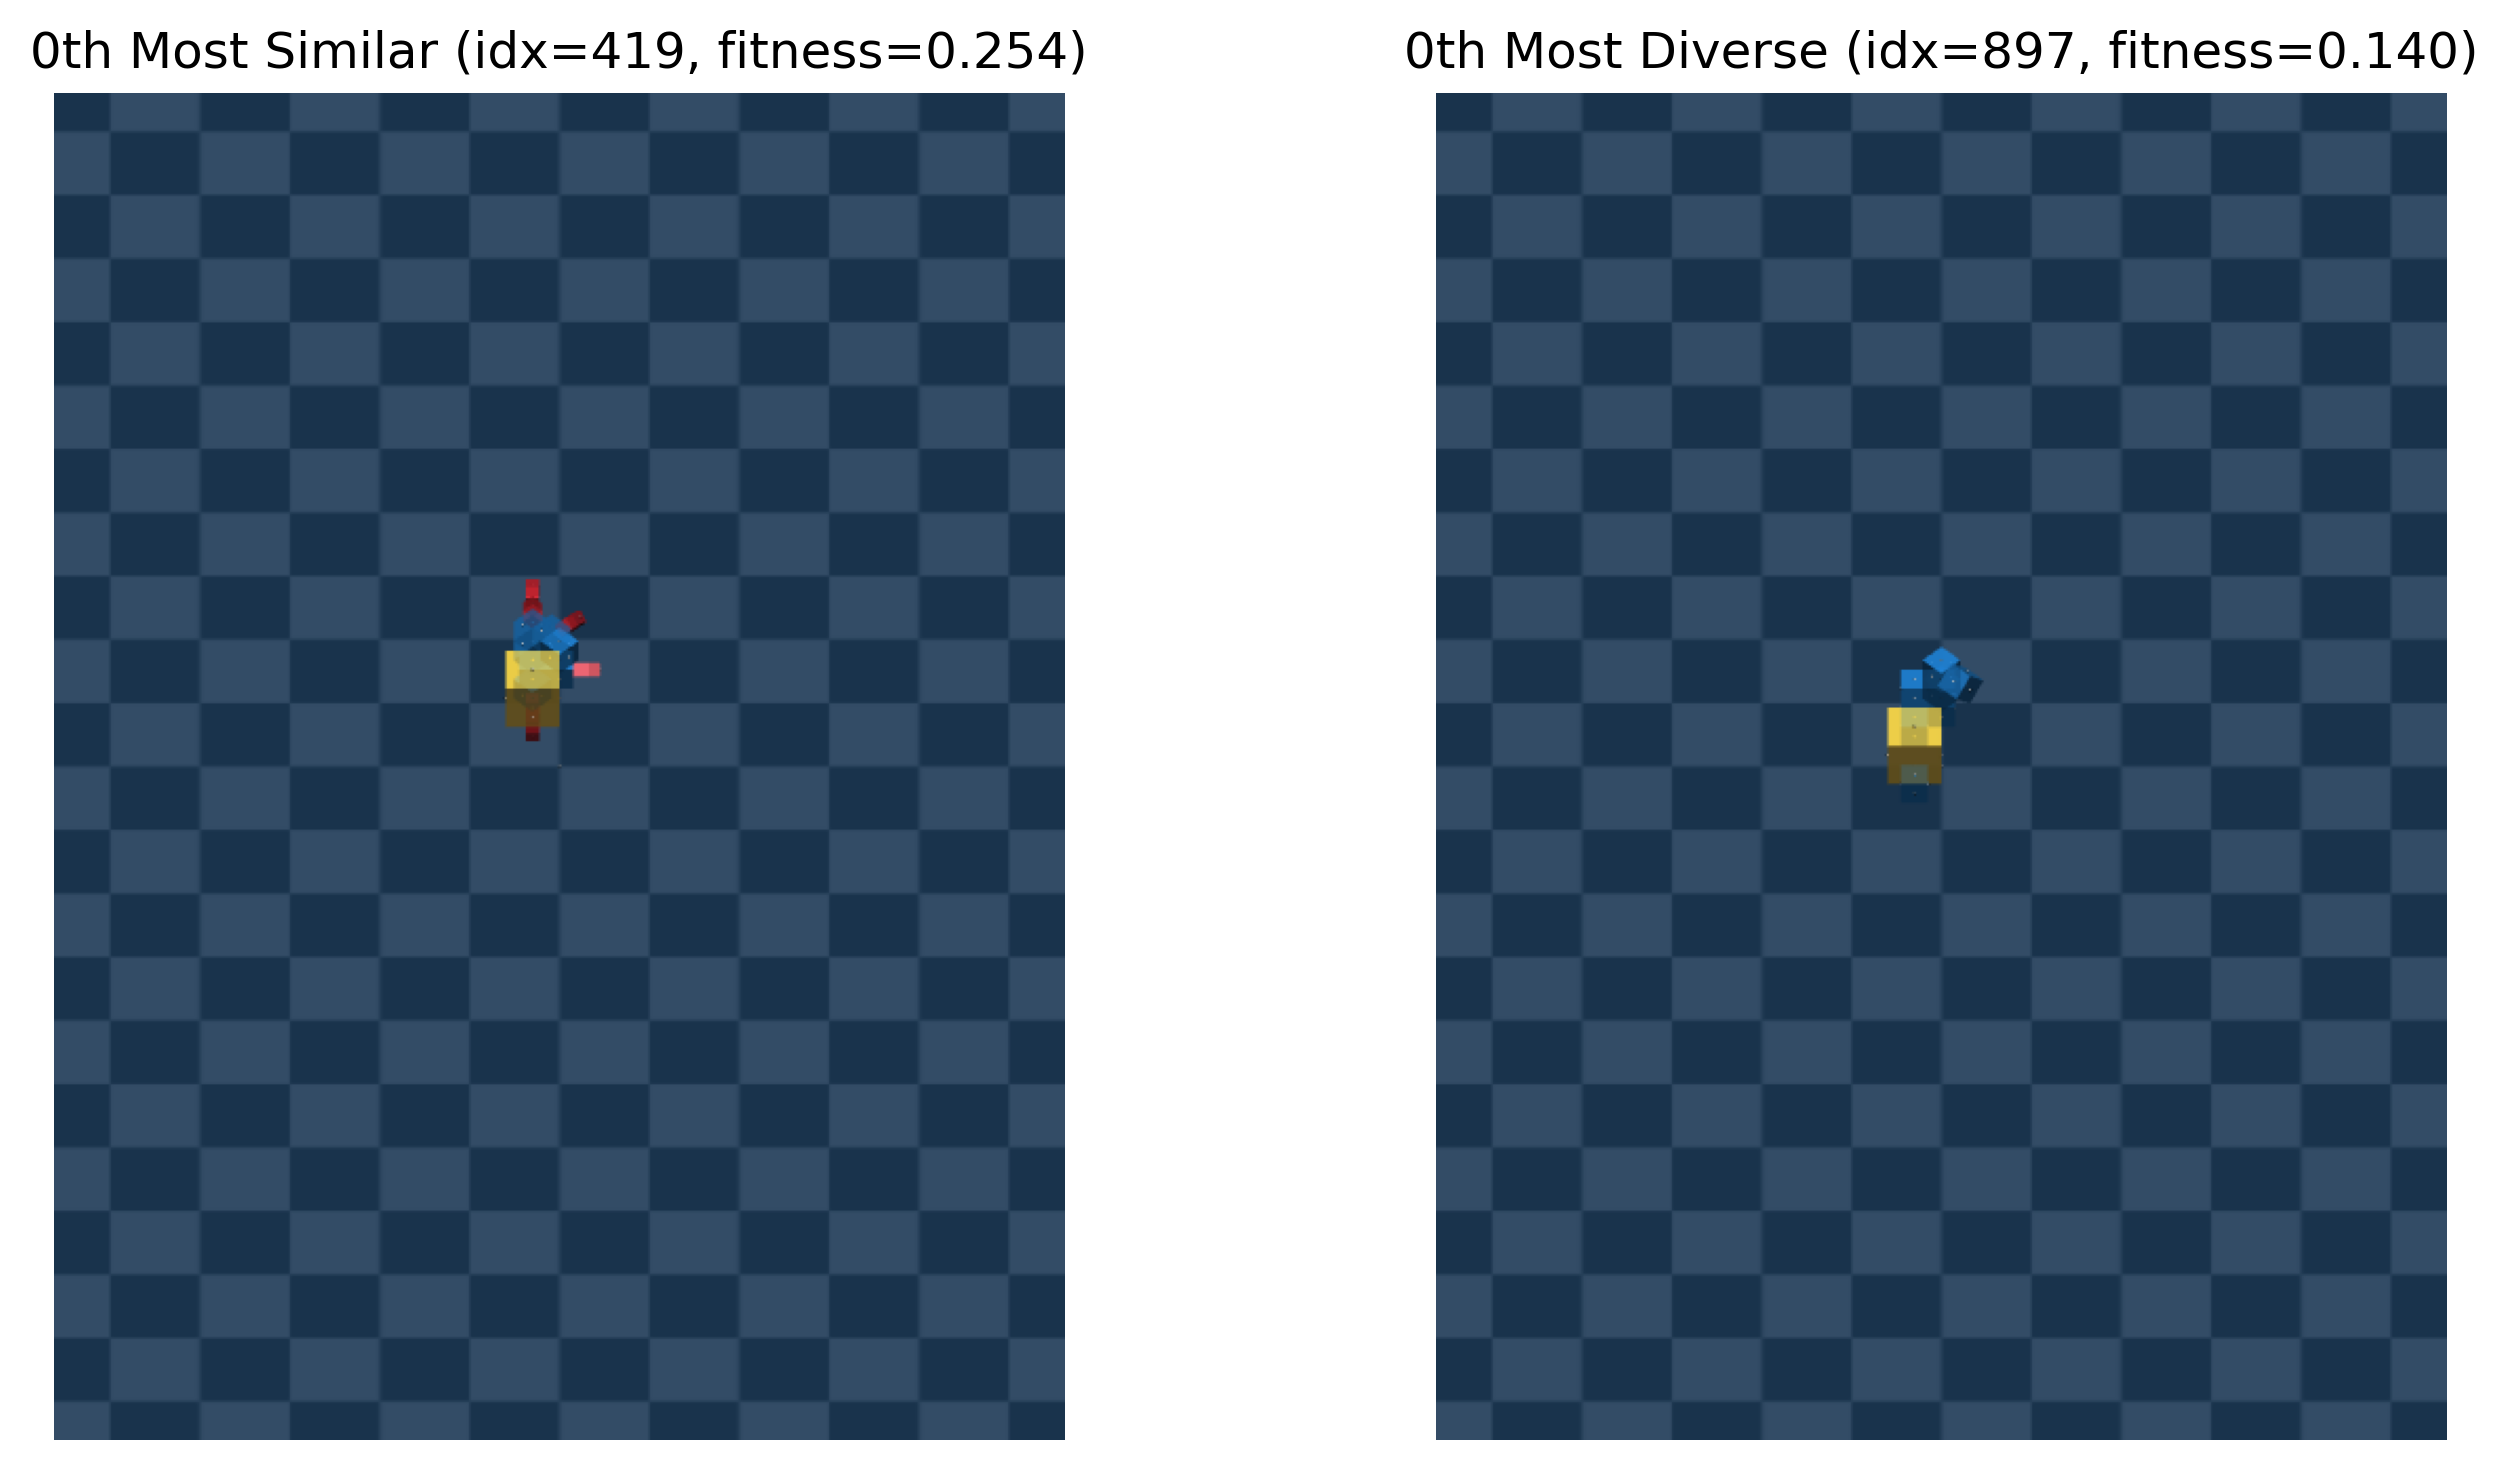

Canonical: C[r(B[b(B1H3H2)r(B[t(B1)]H1)]B1[t(BH1)]BHH1)] and C[l(B)r(BB[r(B[l(B)t(B1)])t(B[r(B[l(B1[t(B1)])])])])]

Similarity between most similar and most diverse: 0.154

In [19]:
# Get most similar (max diversity fitness)
max_dict = analyzed_population.derived['diversity_fitness']['max_first_idx']
max_idx = max_dict['idxs'][tracker]
max_value = max_dict['values'][tracker]

# Get most diverse (min diversity fitness)
min_dict = analyzed_population.derived['diversity_fitness']['min_first_idx']
min_idx = min_dict['idxs'][tracker]
min_value = min_dict['values'][tracker]

# Create canonicalized nodes
node_most_similar = ctk.from_graph(population[max_idx]).canonicalize()
node_most_diverse = ctk.from_graph(population[min_idx]).canonicalize()

# Plot side by side
plot_two_mujocos(
    node_most_similar.to_graph(),
    node_most_diverse.to_graph(),
    [
        f"{tracker}th Most Similar (idx={max_idx}, fitness={max_value:.3f})",
        f"{tracker}th Most Diverse (idx={min_idx}, fitness={min_value:.3f})"
    ]
)

console.print(f"Canonical: {ctk.to_canonical_string(node_most_similar)} and {ctk.to_canonical_string(node_most_diverse)}", markup=False, highlight=False)

# Calculate similarity between them
similarity = ctk.calculate_similarity(node_most_similar, node_most_diverse, config=similarity_config)
console.print(f"\n[yellow]Similarity between most similar and most diverse:[/yellow] {similarity:.3f}")

tracker = (tracker + 1) % len(population)

-----

##### Manual trial-and-error

import gecko

In [20]:
gecko = ctk.from_string("C[fb(H2H2B)r(HBHB[l(H1B)r(H3B)])]")

mutate brick -> hinge close to root

In [21]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(HHHB[l(H1B)r(H3B)])]")

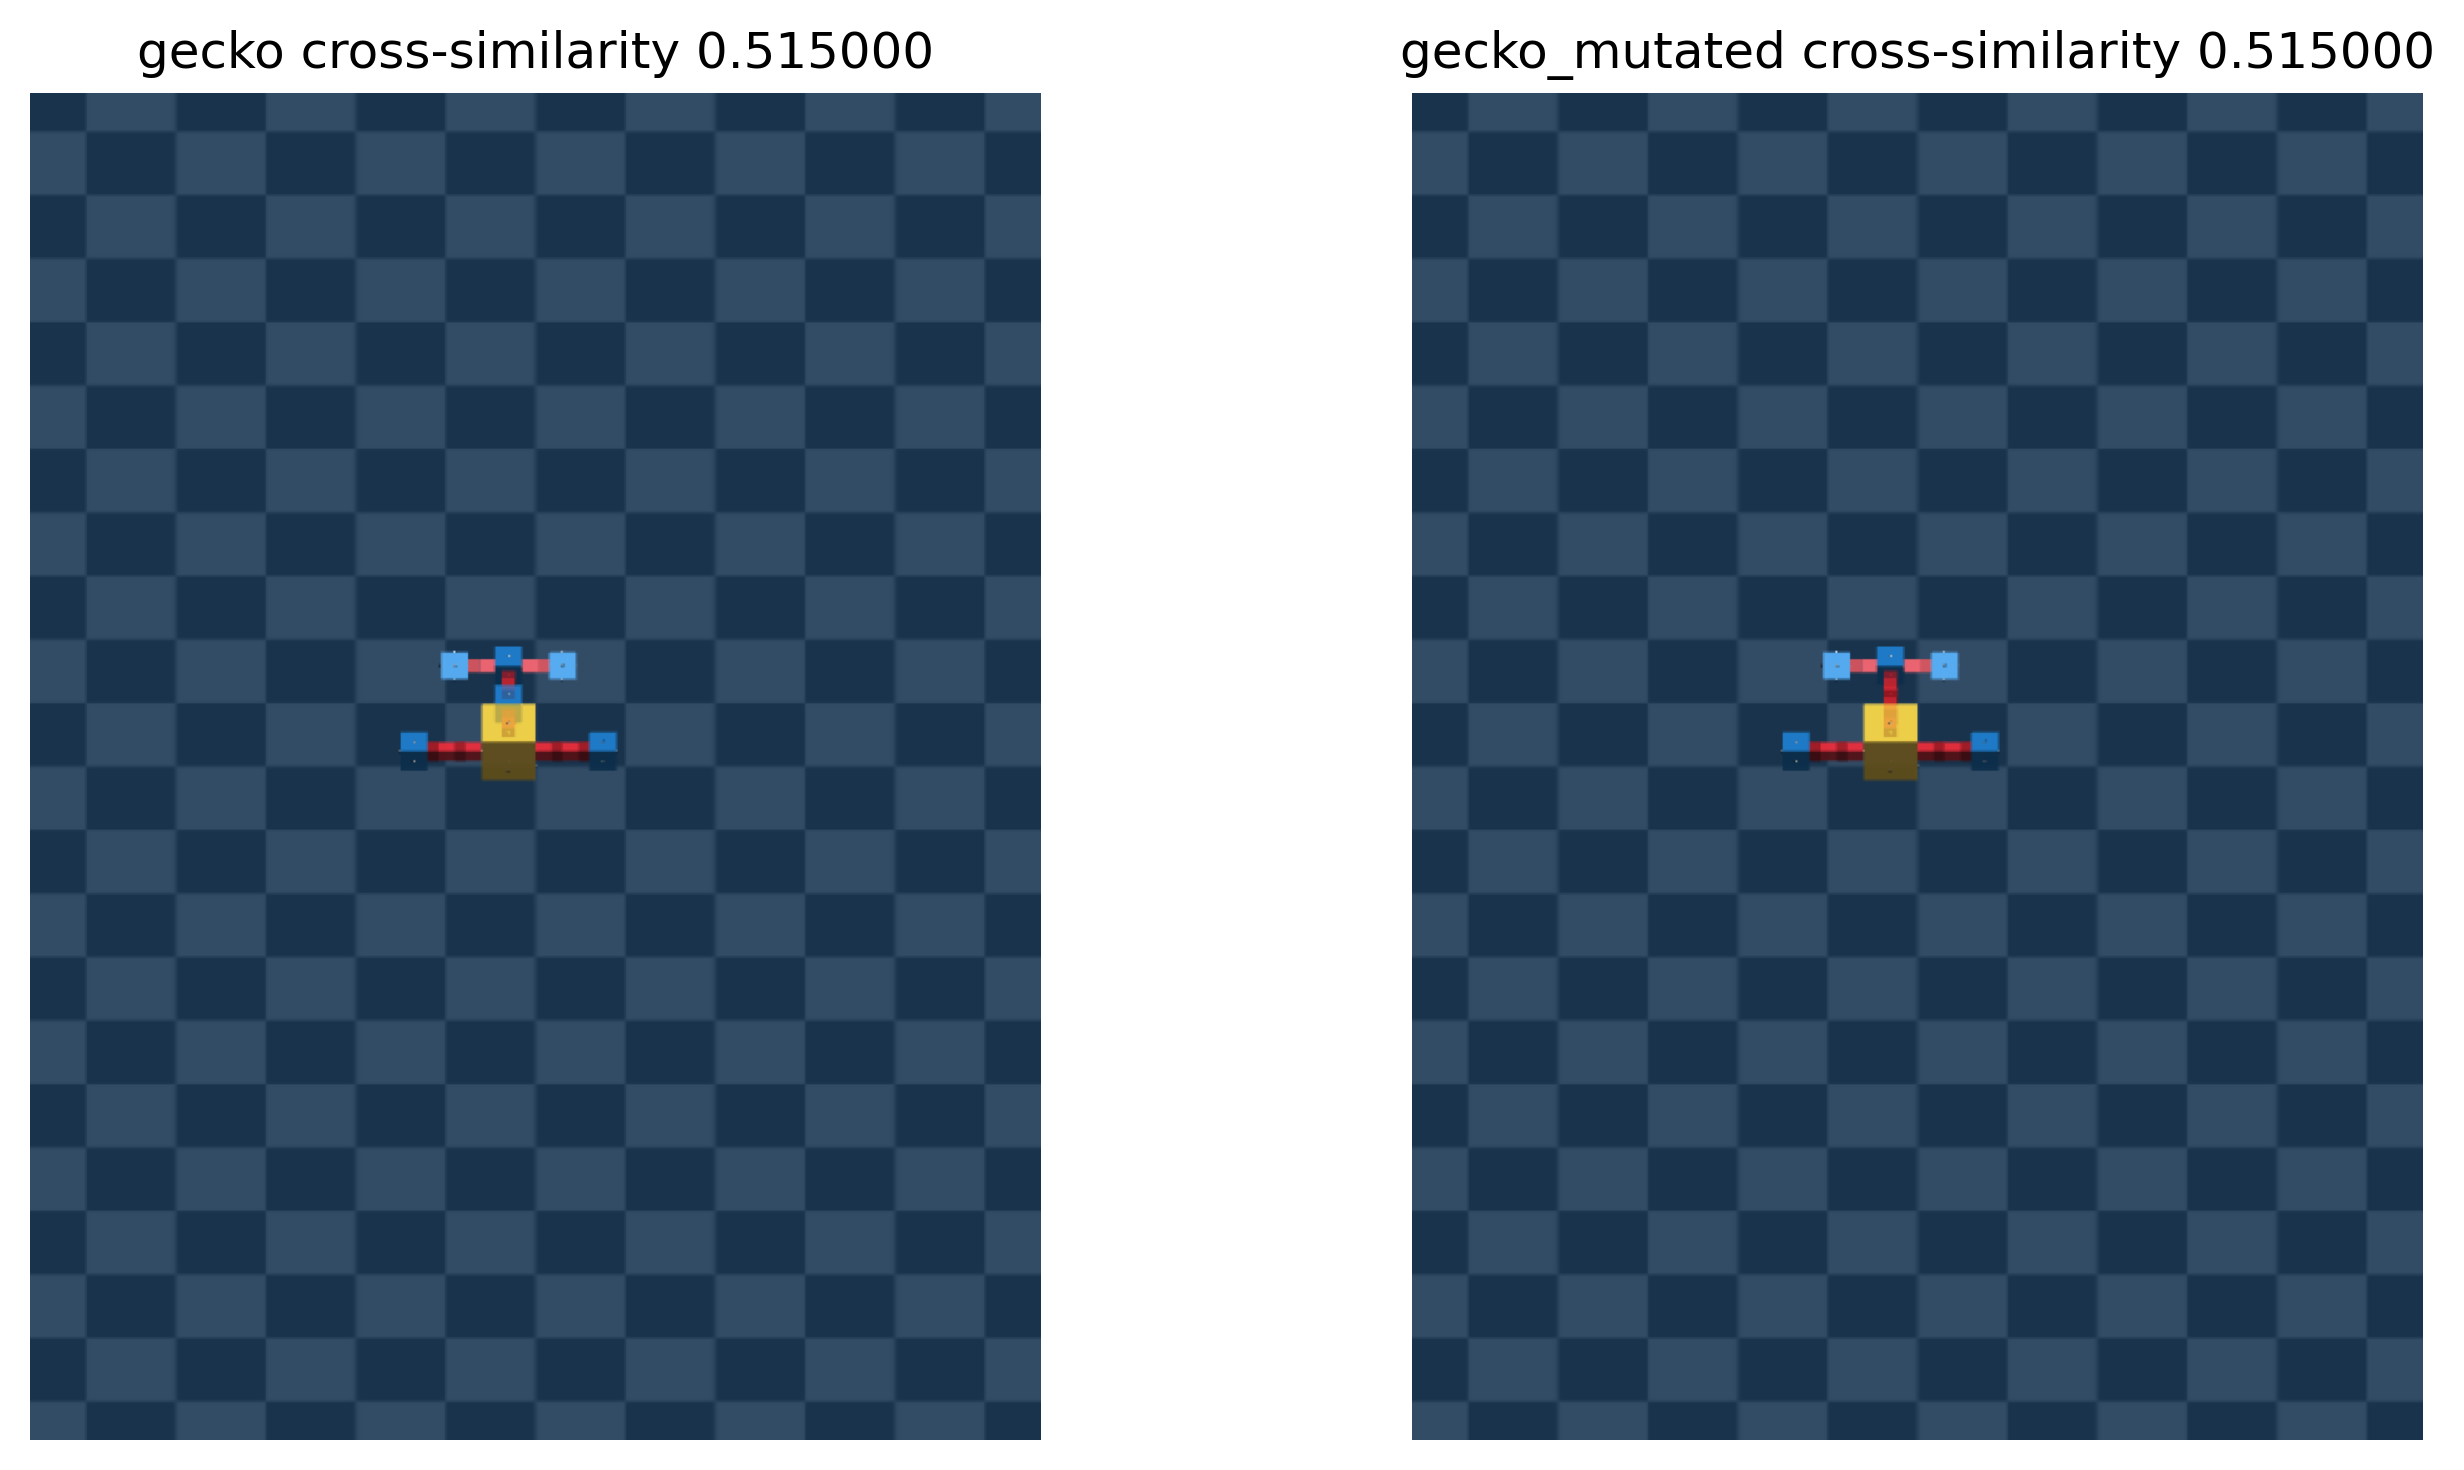

In [22]:
similarity = ctk.calculate_similarity(gecko, gecko_mut, config=similarity_config)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [f'gecko cross-similarity {similarity:2f}', f'gecko_mutated cross-similarity {similarity:2f}']
)

mutate brick -> hinge close to leaf

In [23]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(HBHB[l(H1B)r(B3B)])]")

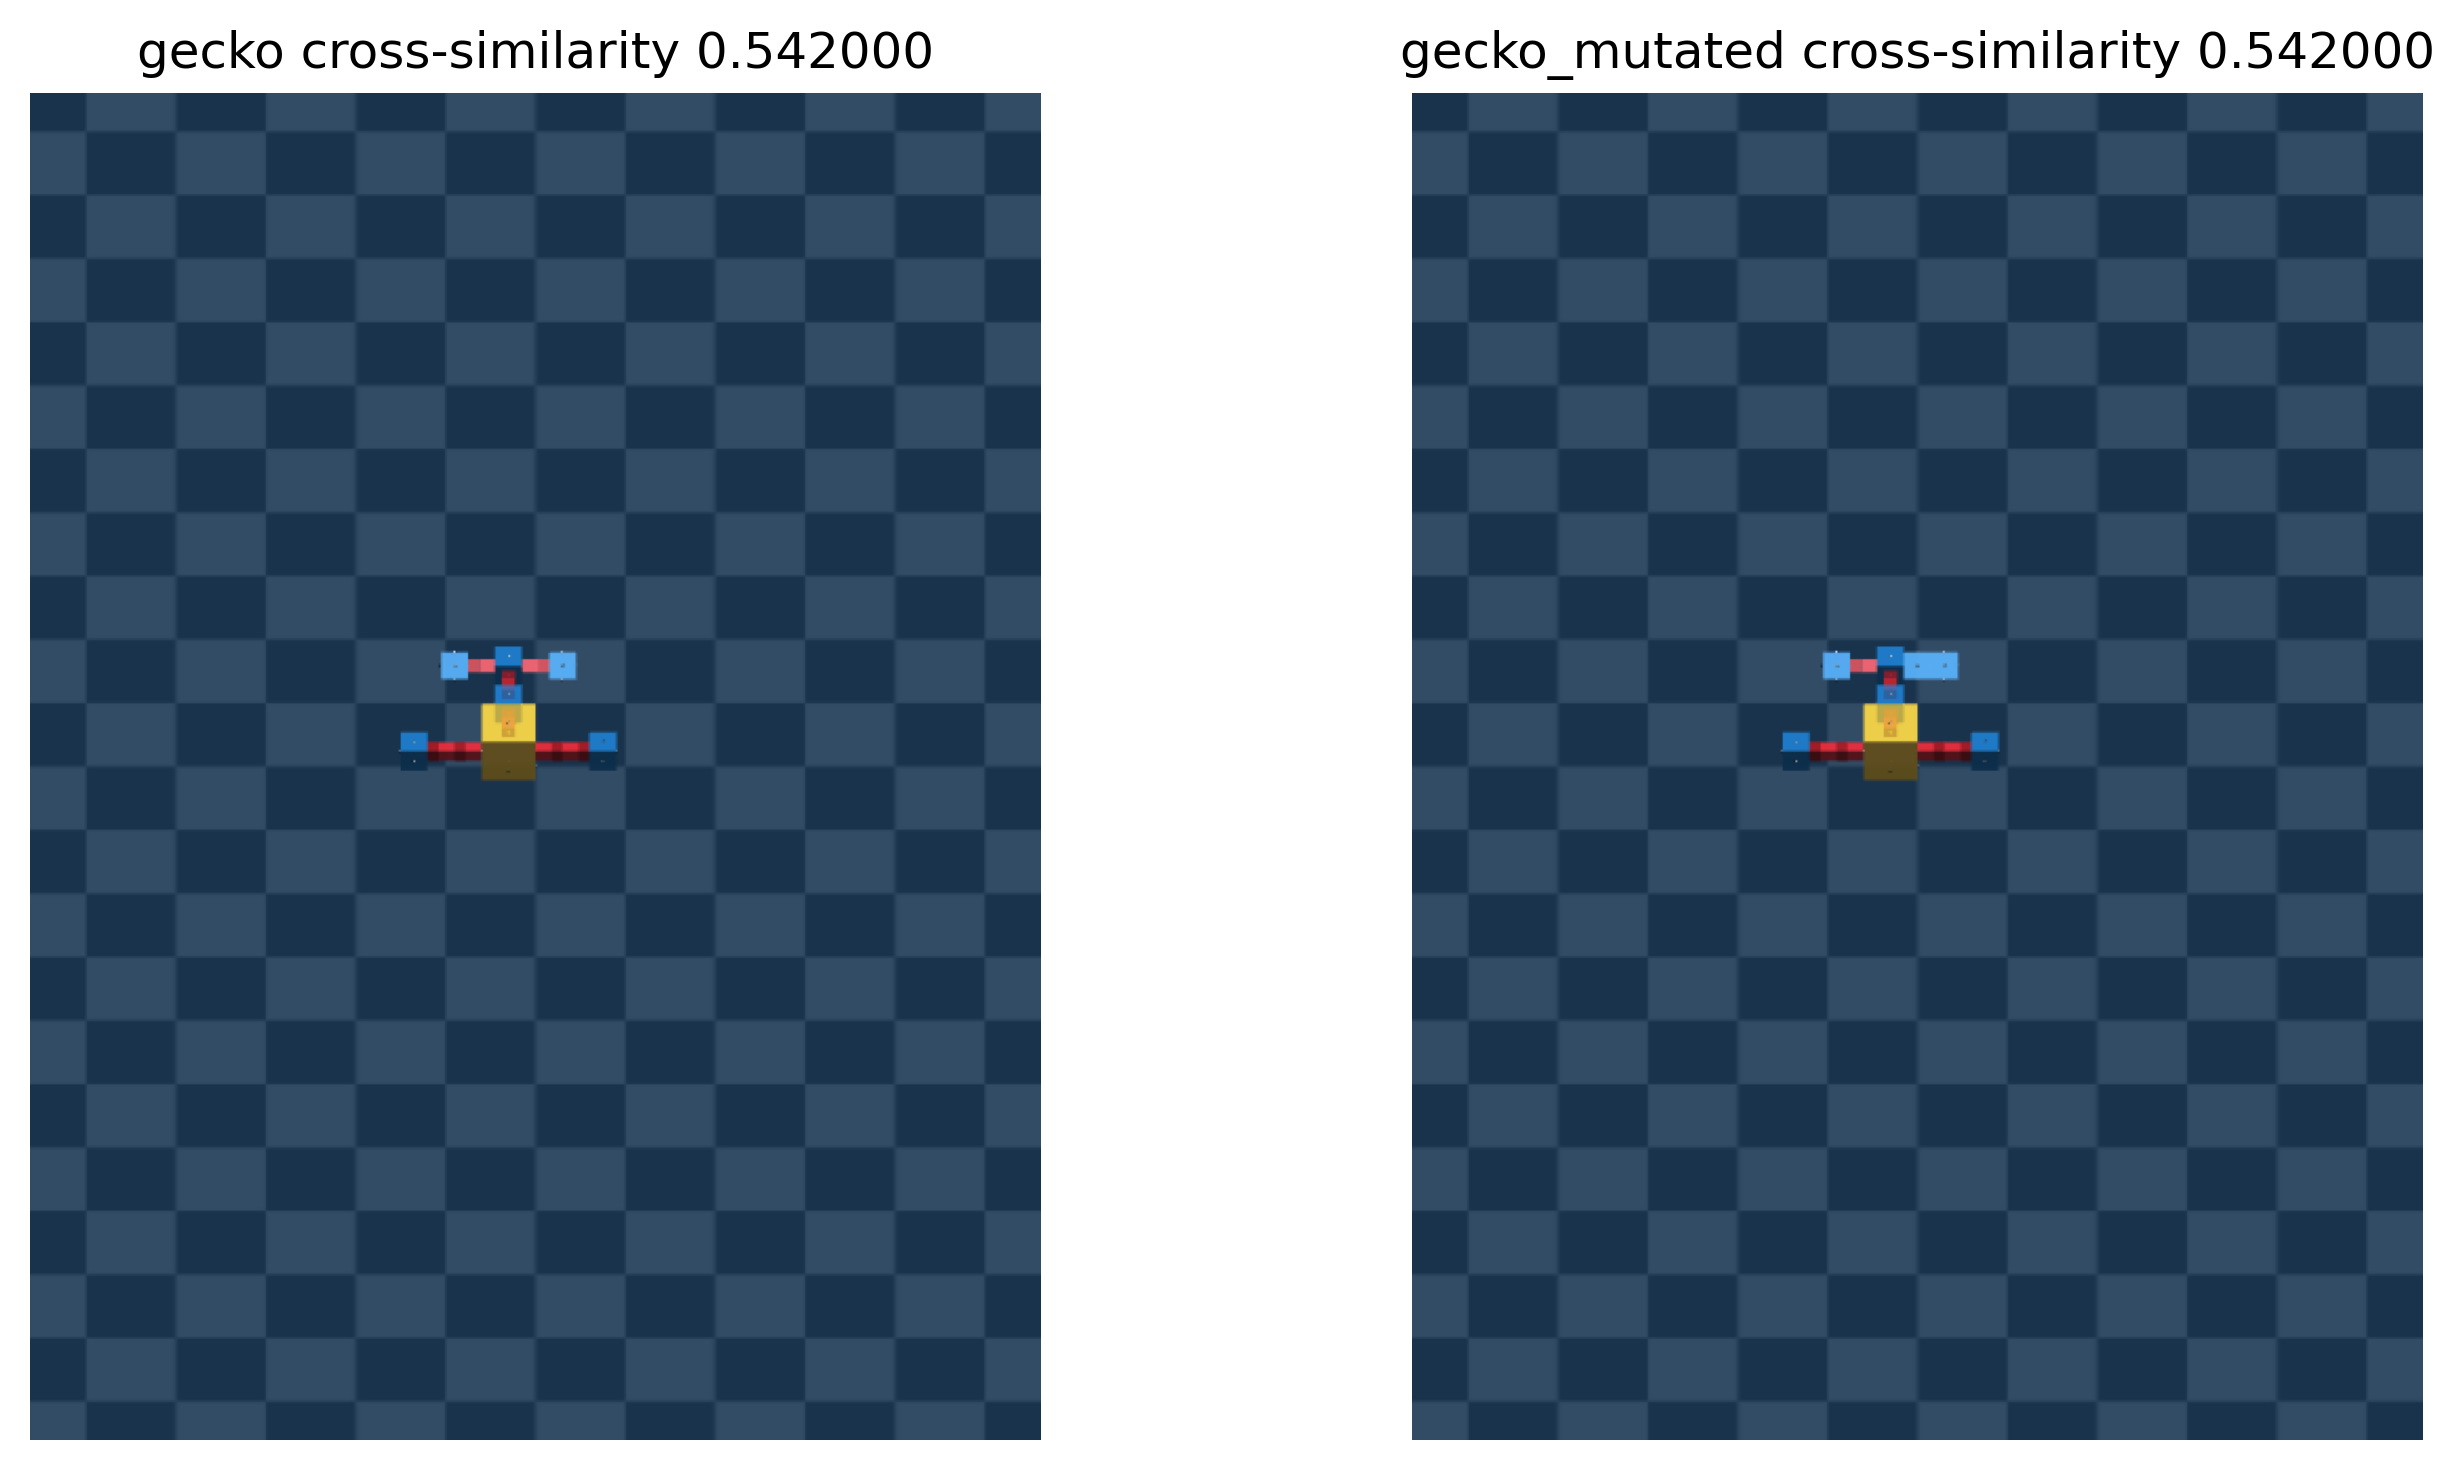

In [24]:
similarity = ctk.calculate_similarity(gecko, gecko_mut, config=similarity_config)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [f'gecko cross-similarity {similarity:2f}', f'gecko_mutated cross-similarity {similarity:2f}']
)

change rotation close to root

In [25]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(H4BHB[l(H1B)r(H3B)])]")

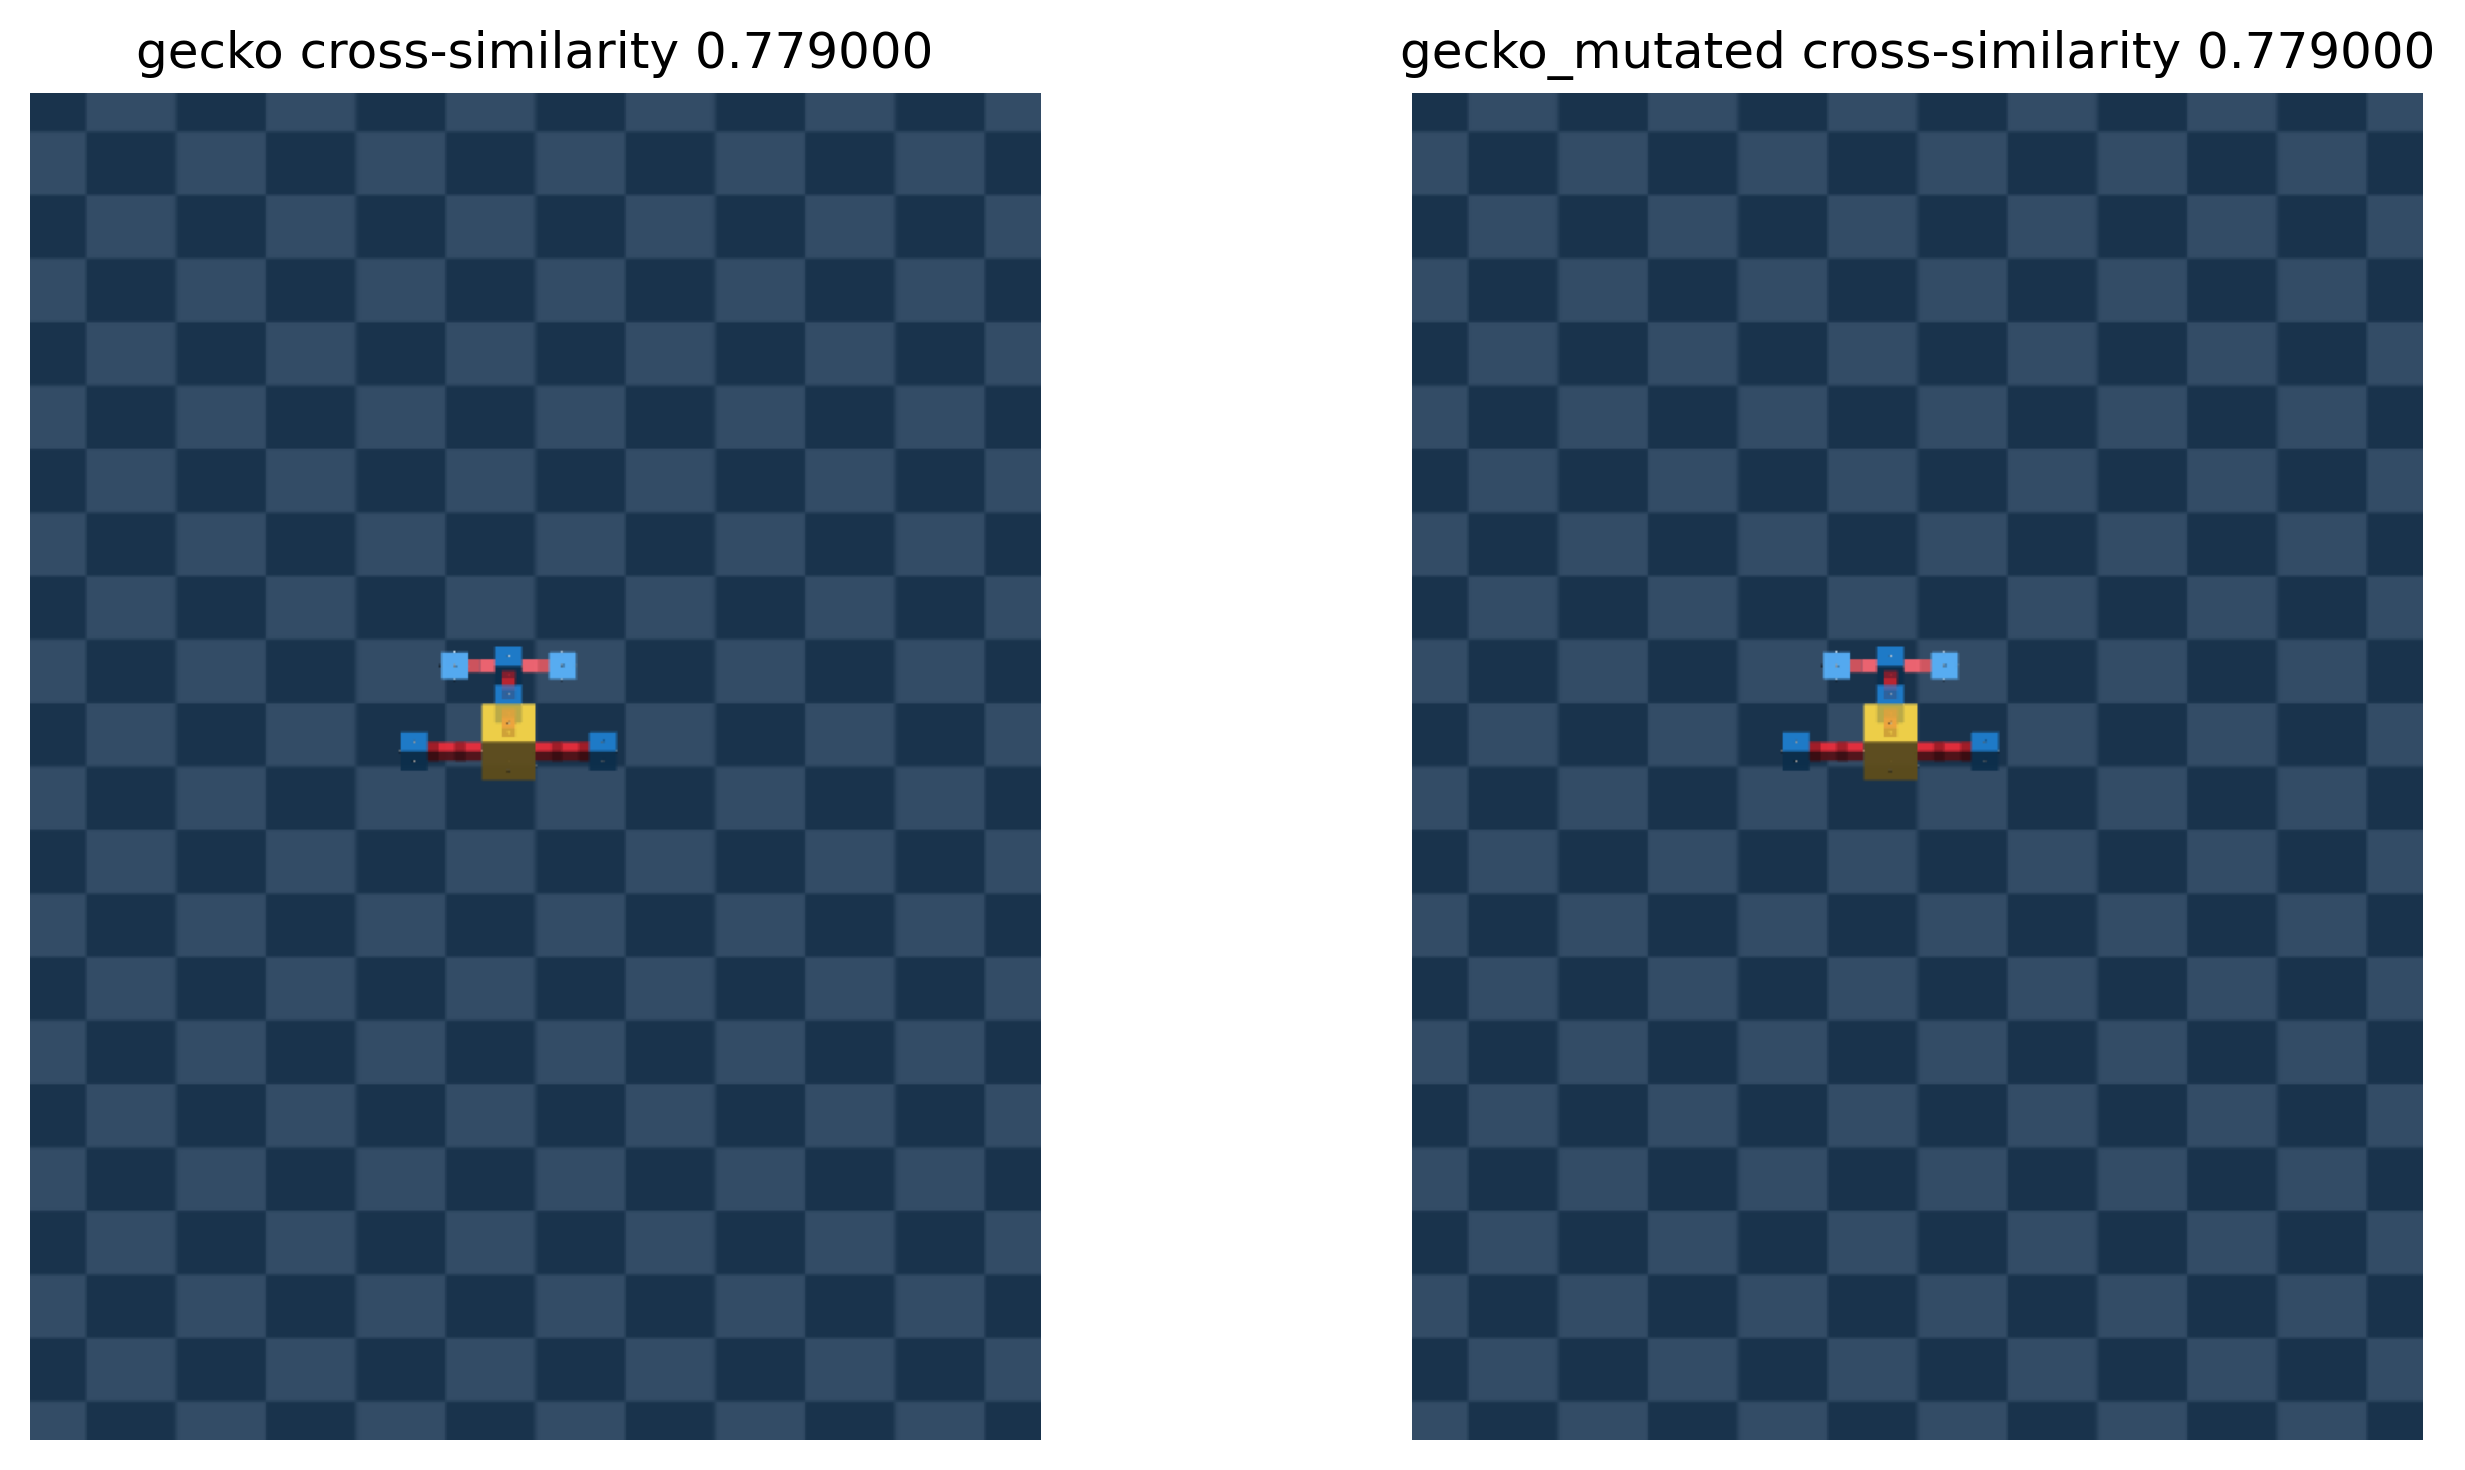

In [26]:
similarity = ctk.calculate_similarity(gecko, gecko_mut, config=similarity_config)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [f'gecko cross-similarity {similarity:2f}', f'gecko_mutated cross-similarity {similarity:2f}']
)

change rotation close to leaf

In [27]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(HBHB[l(H1B)r(H3B1)])]")

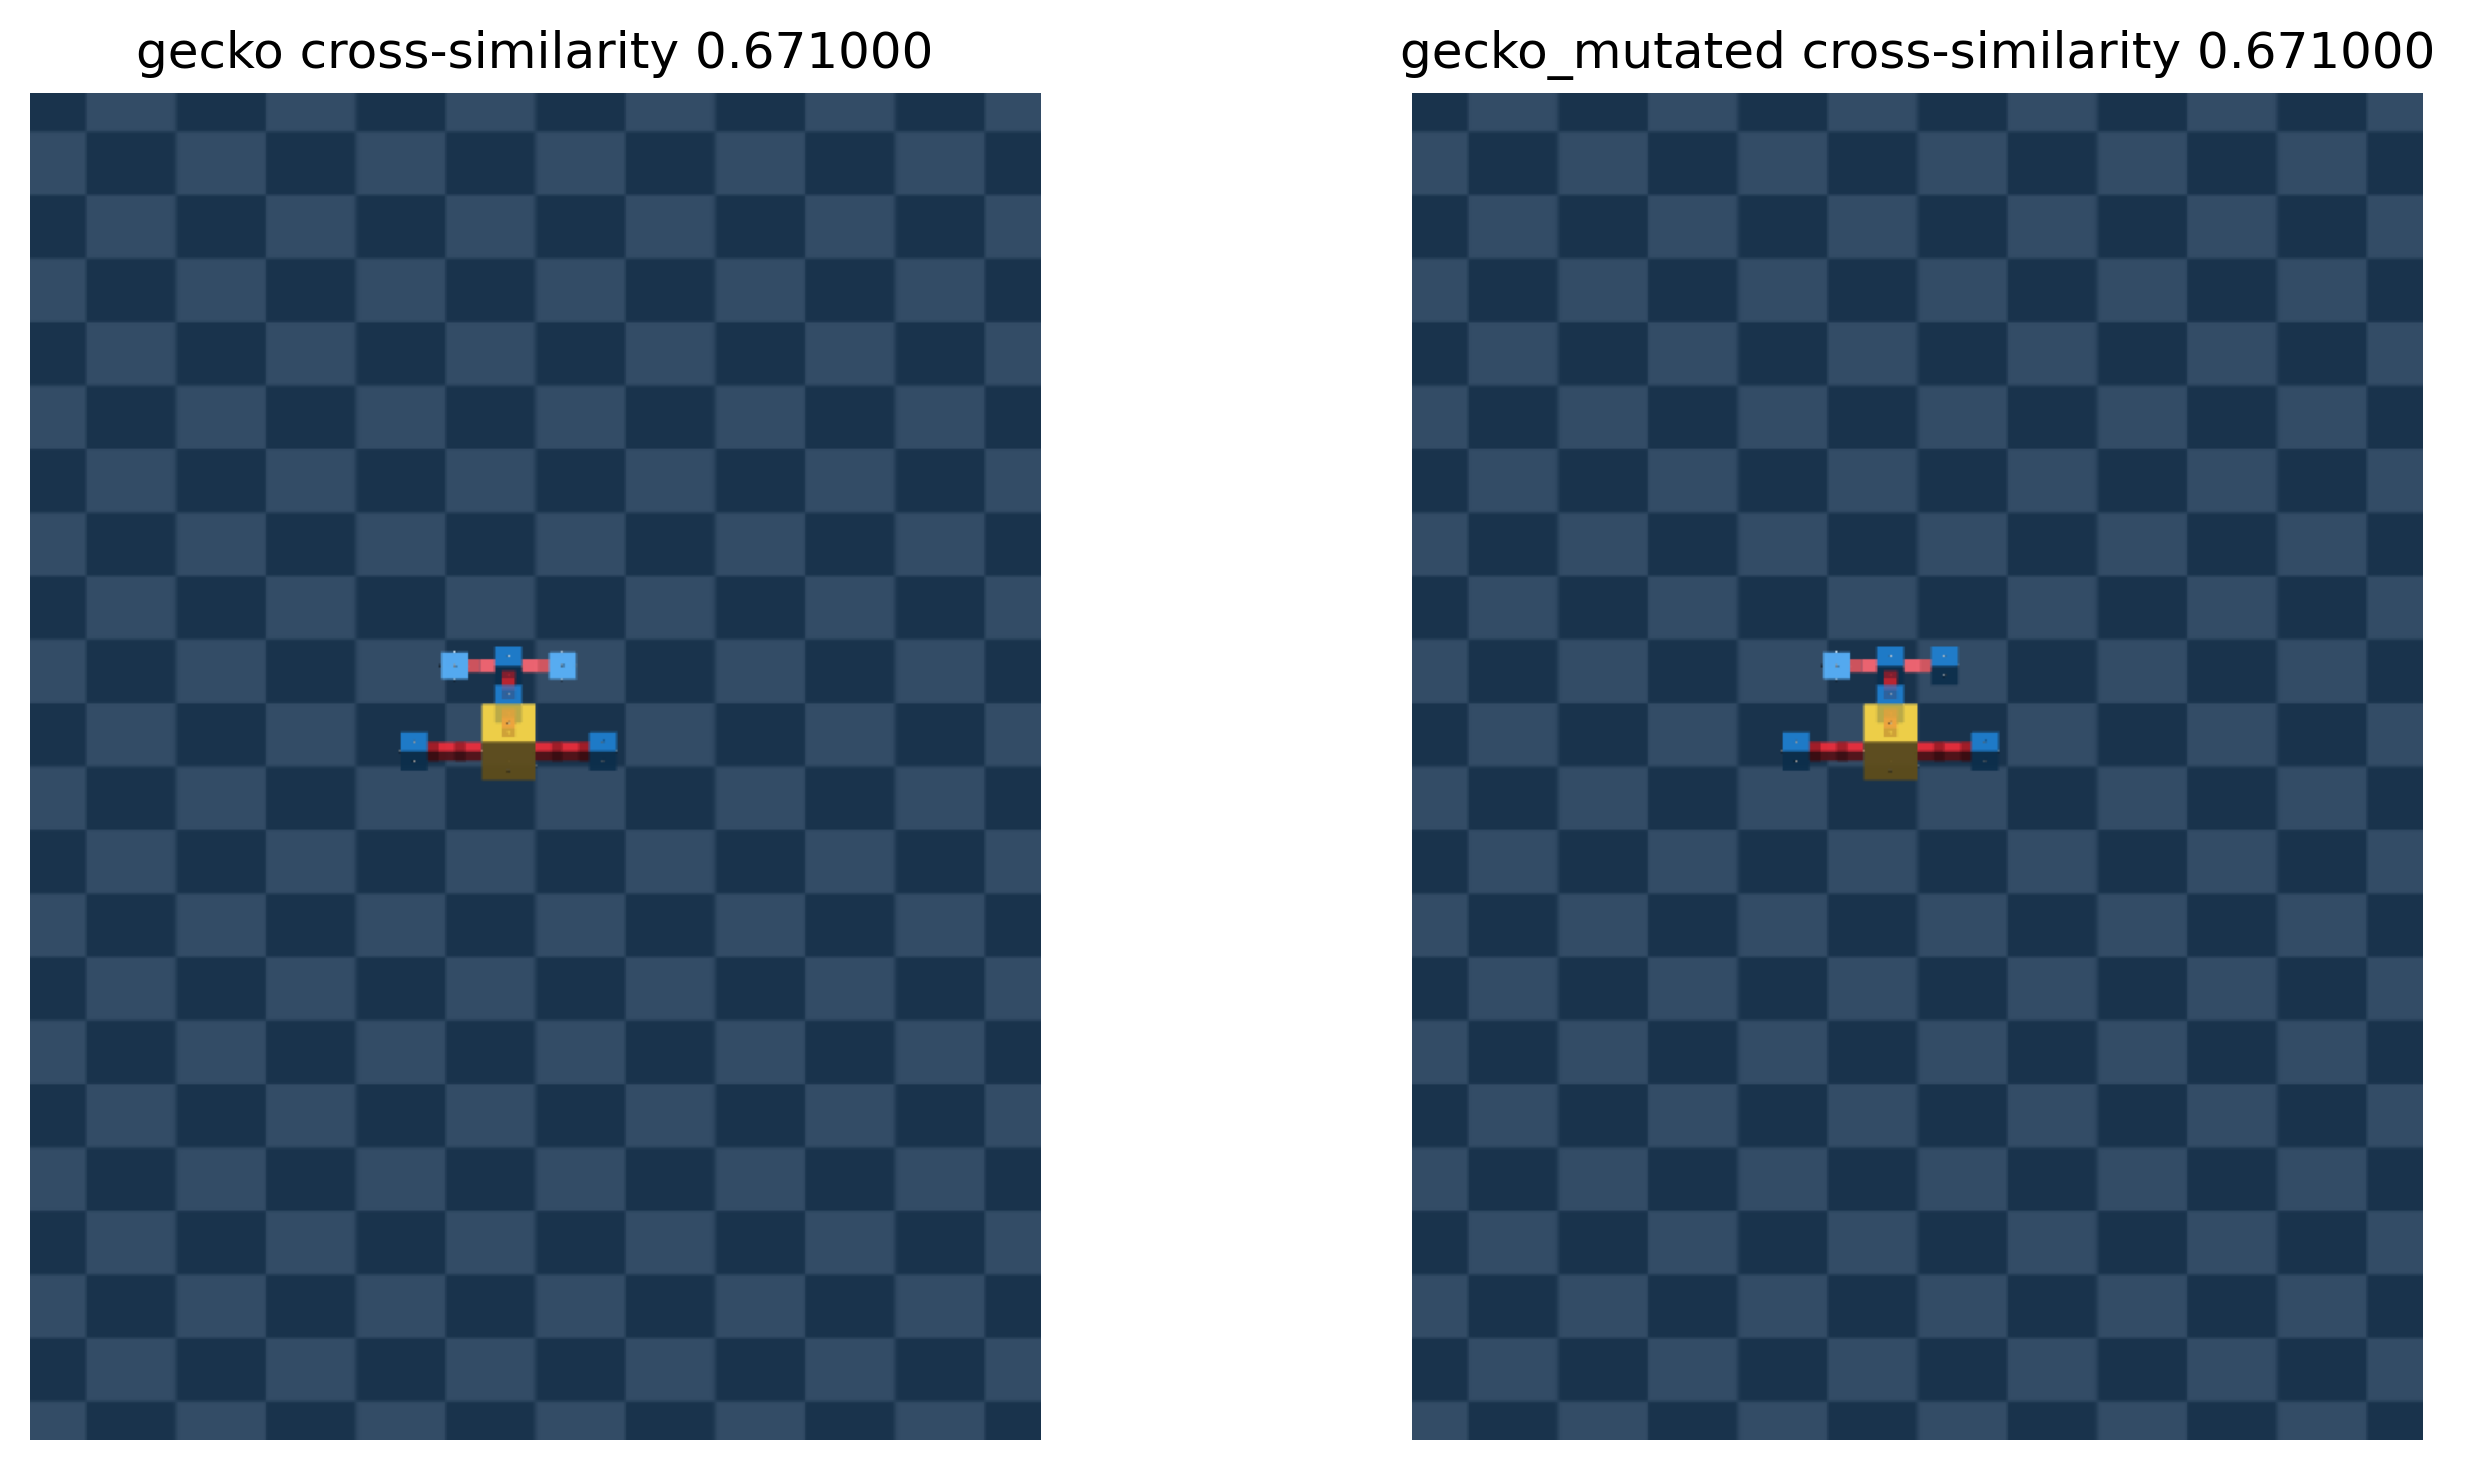

In [28]:
similarity = ctk.calculate_similarity(gecko, gecko_mut, config=similarity_config)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [f'gecko cross-similarity {similarity:2f}', f'gecko_mutated cross-similarity {similarity:2f}']
)

addition

In [29]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(HBHB[l(H1B)r(H3BB)])]")

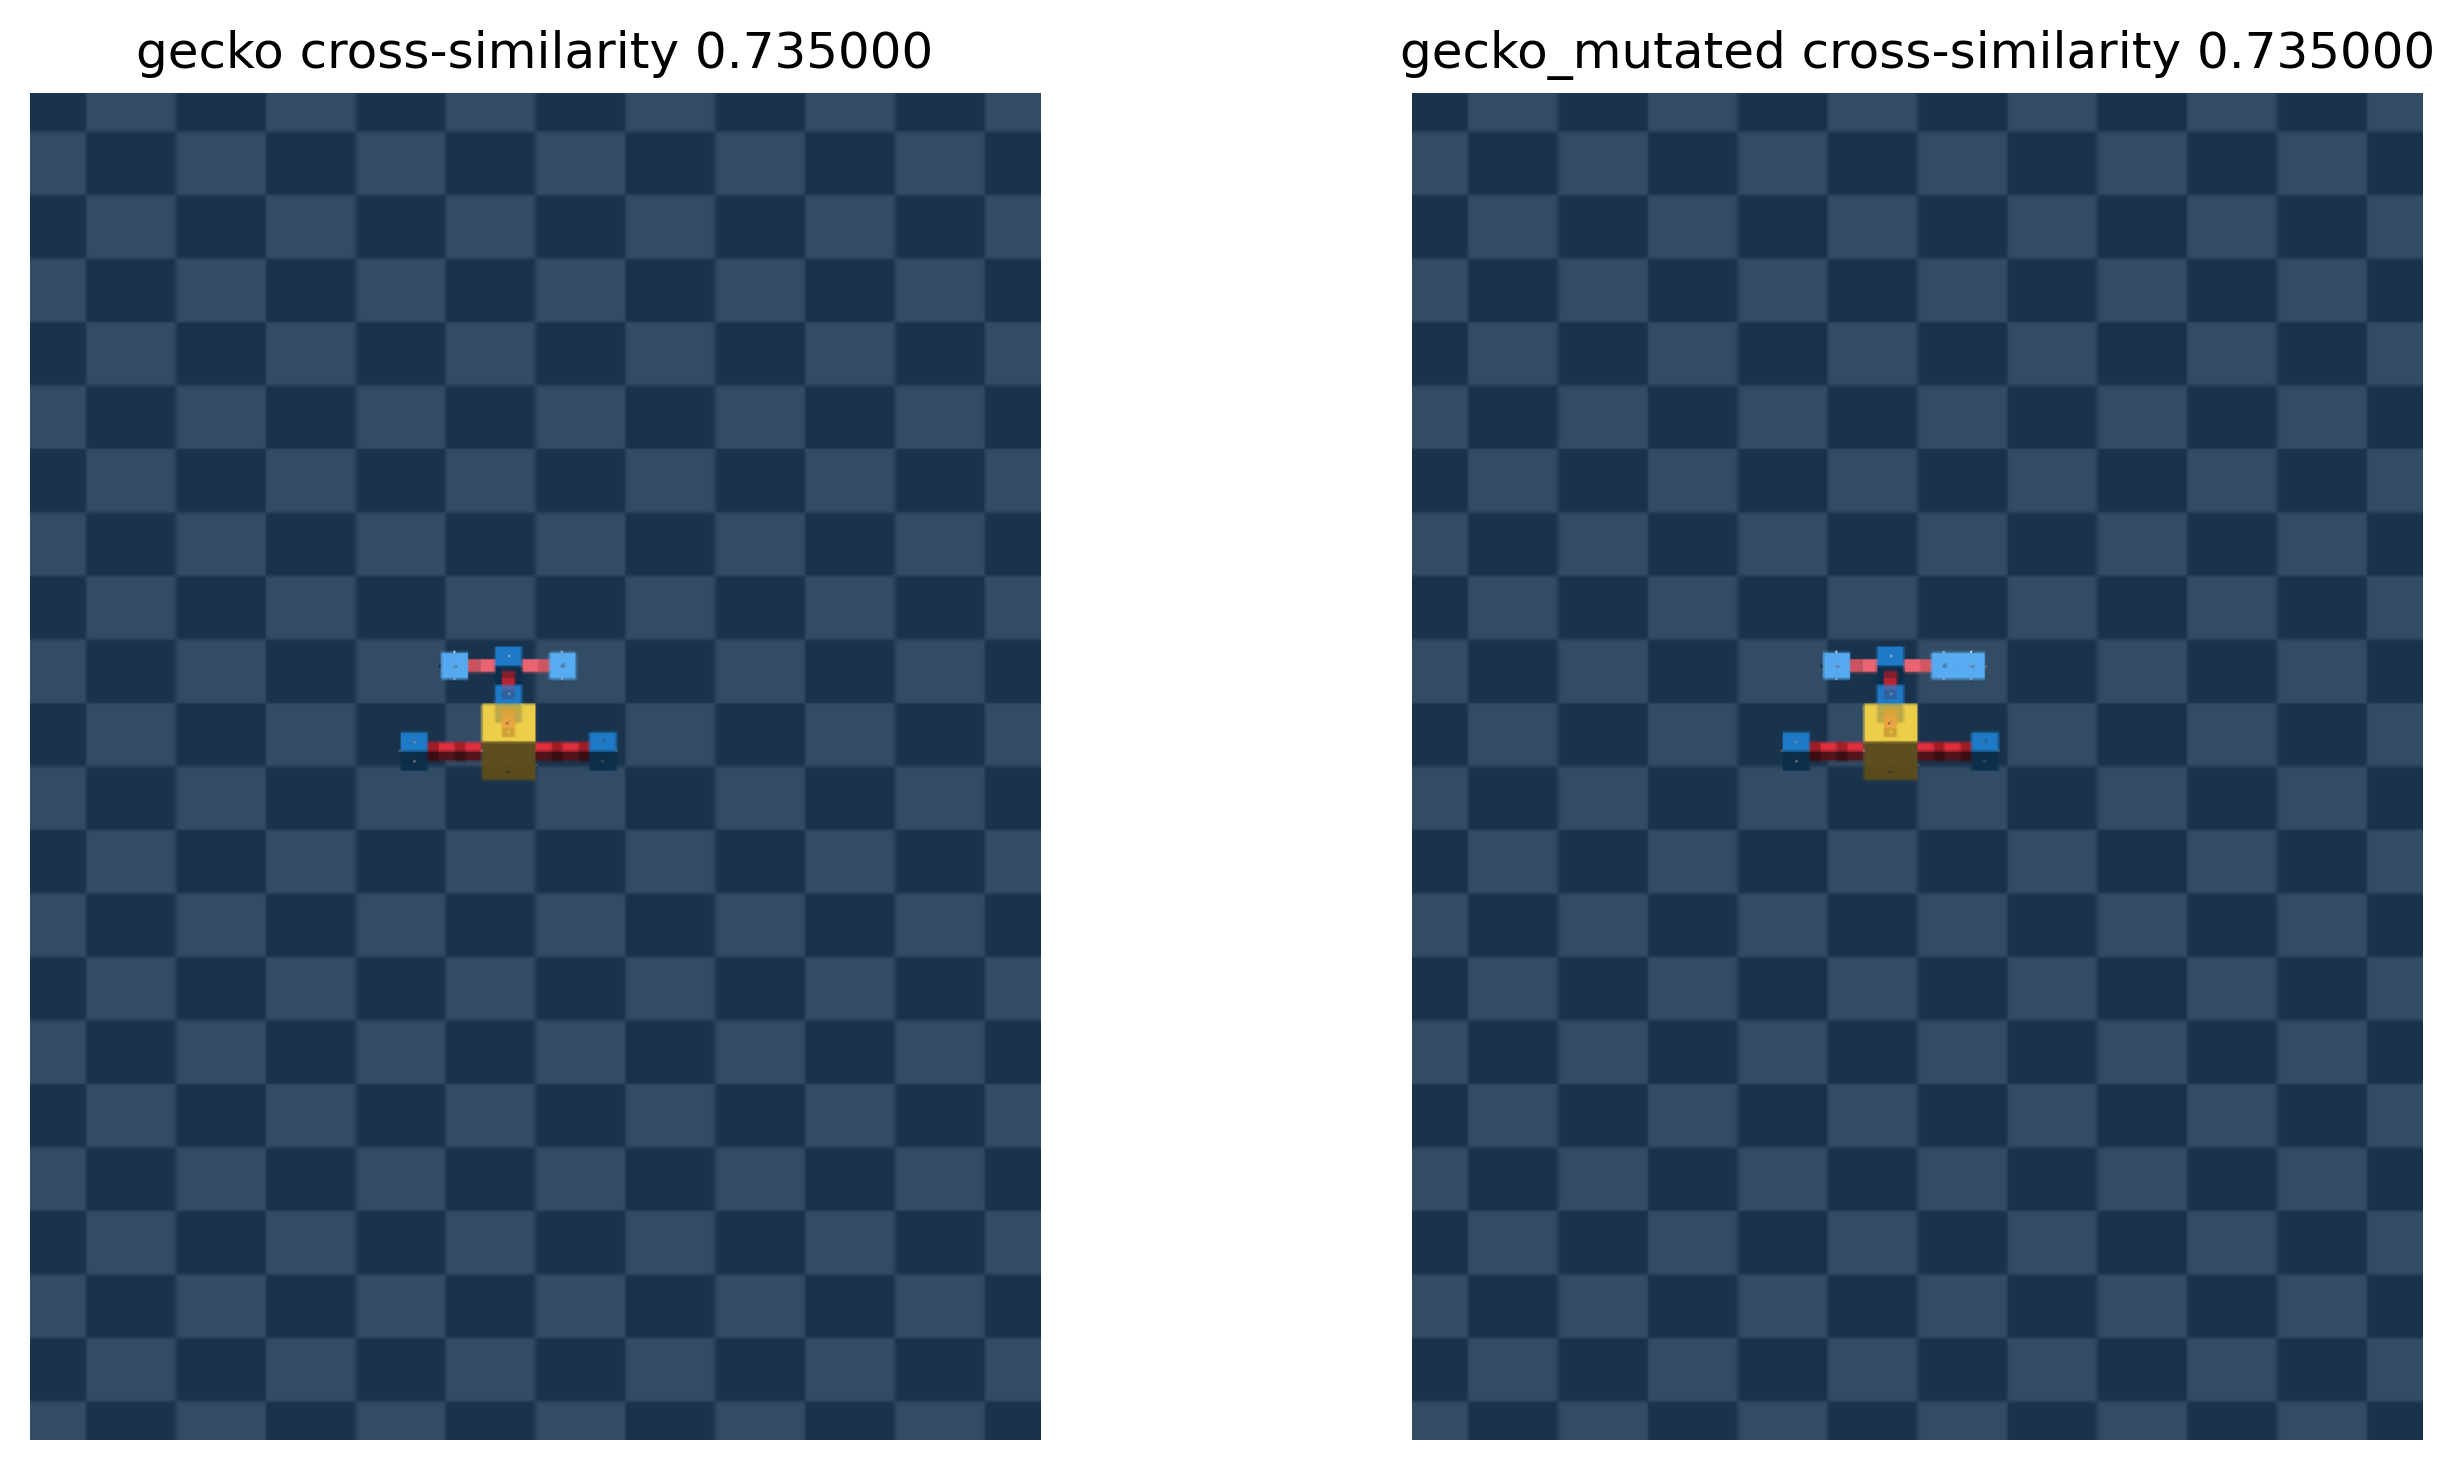

In [30]:
similarity = ctk.calculate_similarity(gecko, gecko_mut, config=similarity_config)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [f'gecko cross-similarity {similarity:2f}', f'gecko_mutated cross-similarity {similarity:2f}']
)

In [31]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(HHBHB[l(H1B)r(H3B)])]")

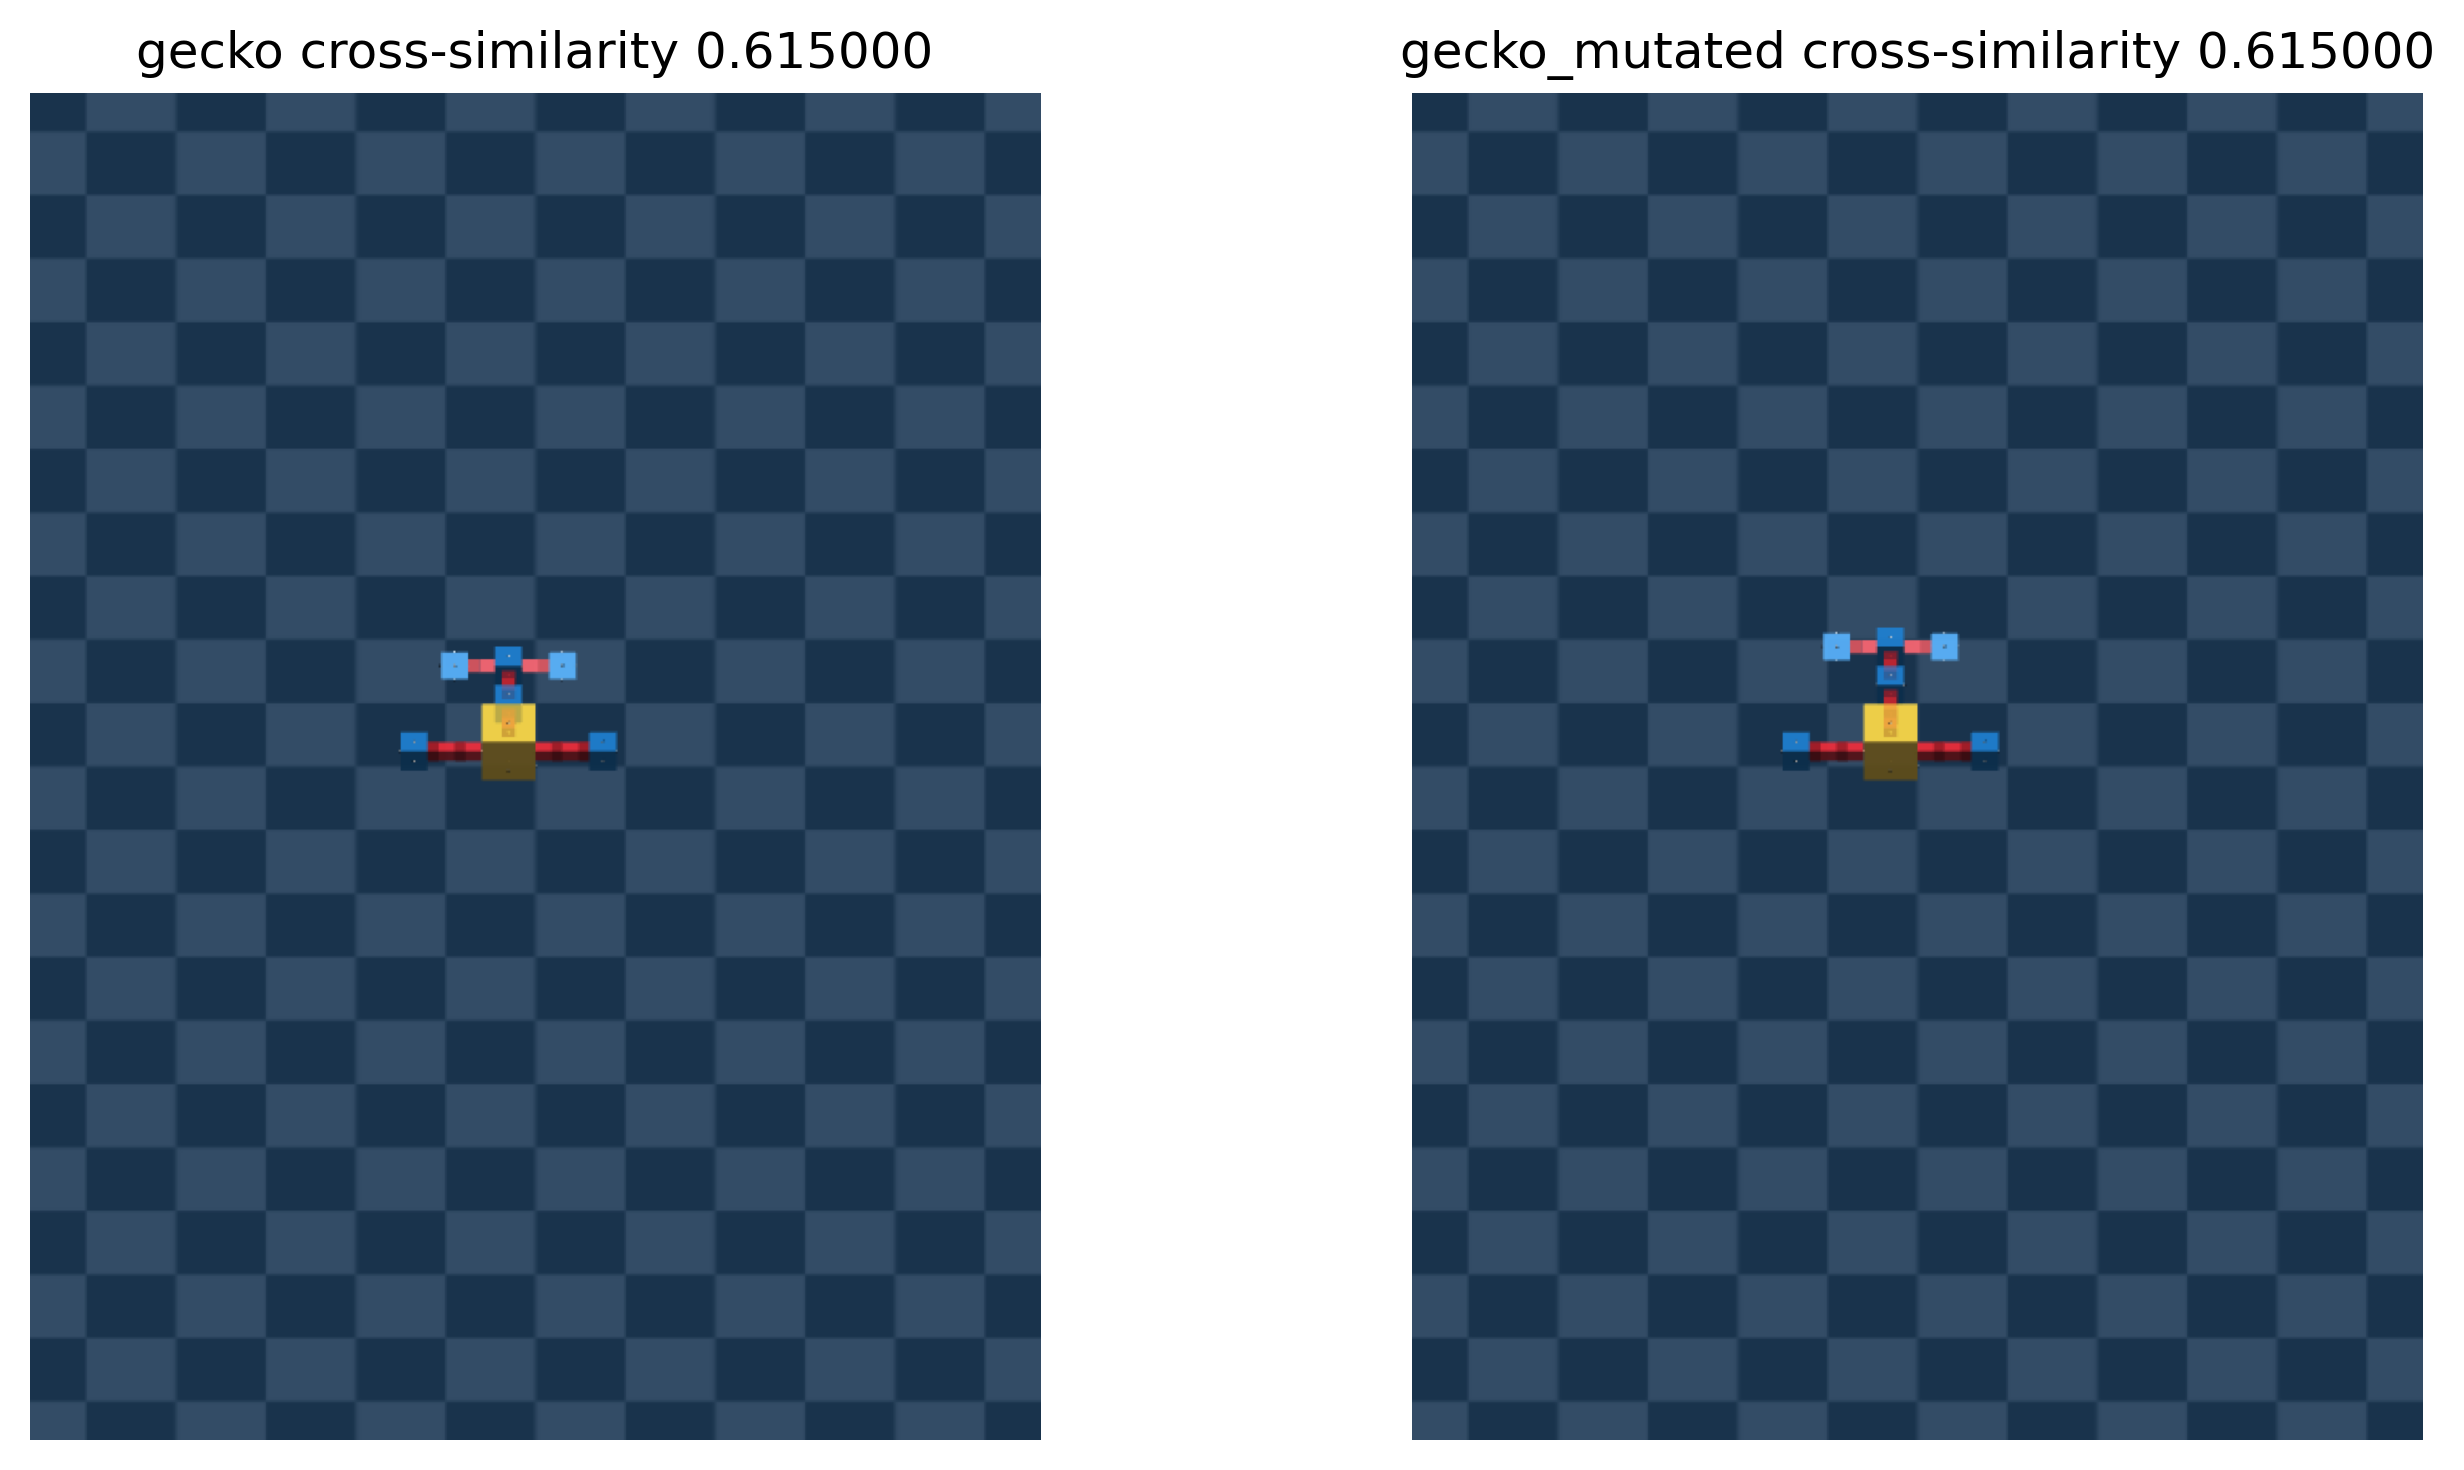

In [32]:
similarity = ctk.calculate_similarity(gecko, gecko_mut, config=similarity_config)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [f'gecko cross-similarity {similarity:2f}', f'gecko_mutated cross-similarity {similarity:2f}']
)

deletion close to root

In [33]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(BHB[l(H1B)r(H3B)])]")

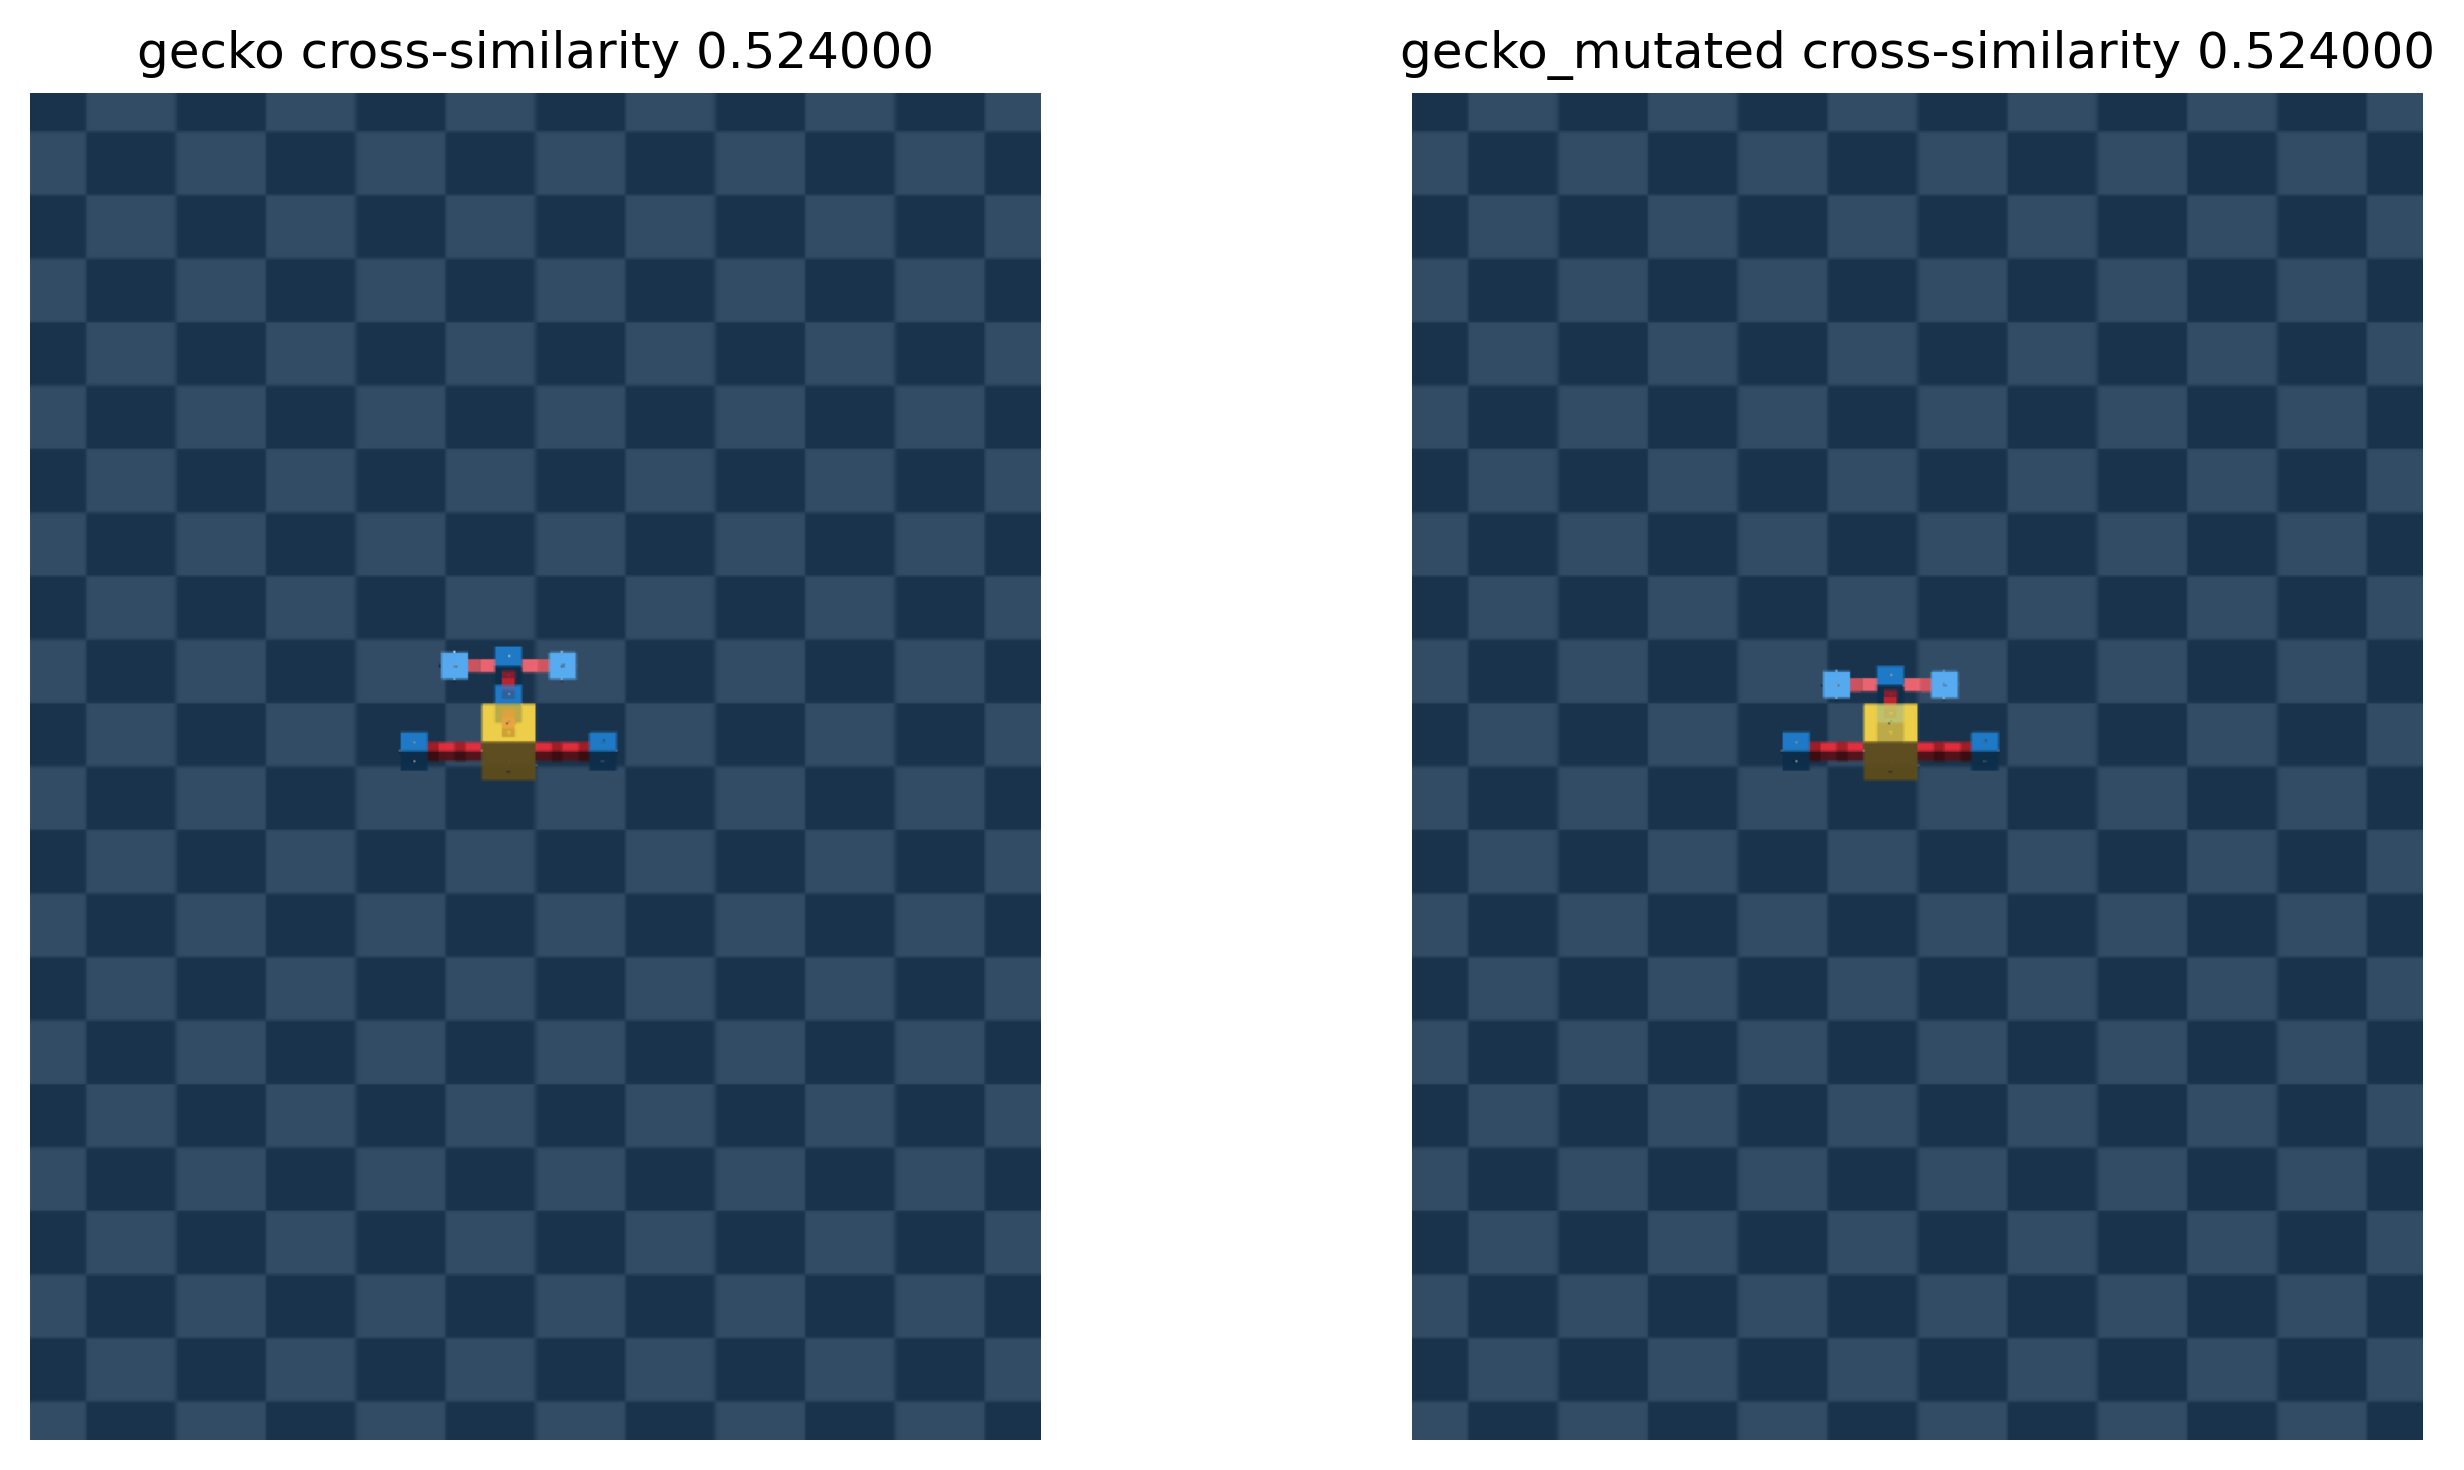

In [34]:
similarity = ctk.calculate_similarity(gecko, gecko_mut, config=similarity_config)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [f'gecko cross-similarity {similarity:2f}', f'gecko_mutated cross-similarity {similarity:2f}']
)

deletion close to leaf

In [35]:
gecko_mut = ctk.from_string("C[fb(H2H2B)r(HBHB[l(H1B)r(H3)])]")

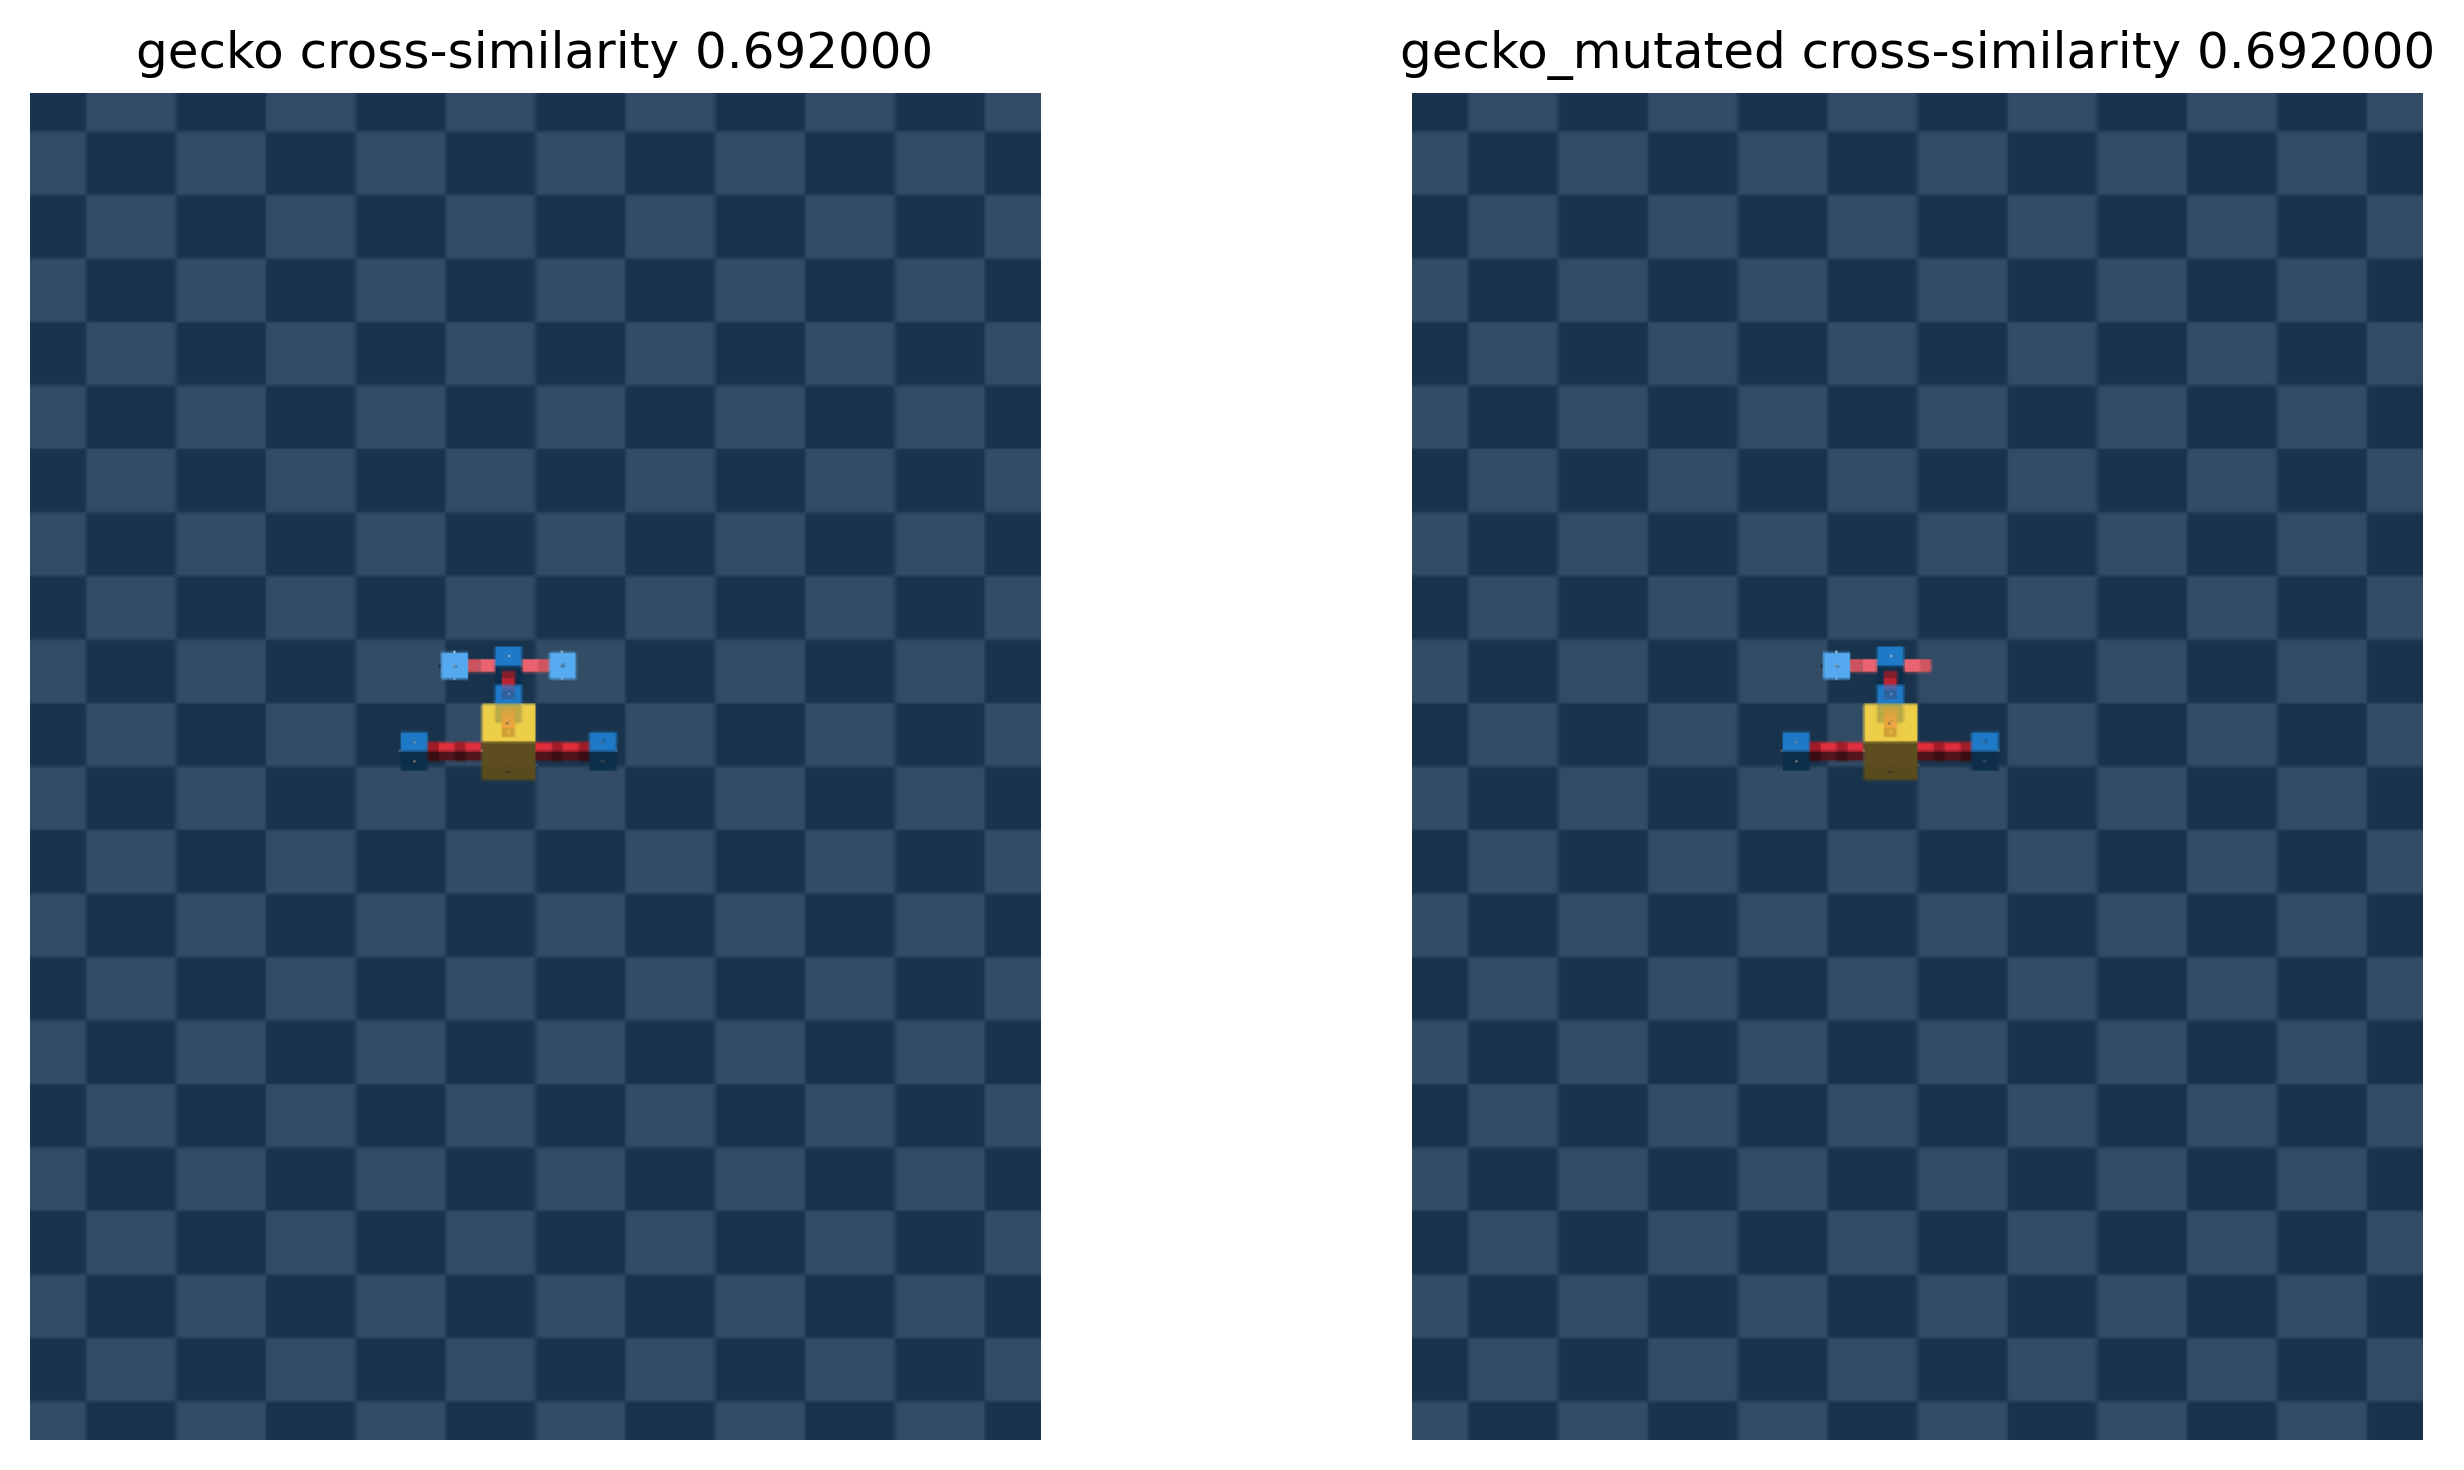

In [36]:
similarity = ctk.calculate_similarity(gecko, gecko_mut, config=similarity_config)
plot_two_mujocos(
    gecko.to_graph(),
    gecko_mut.canonicalize().to_graph(),
    [f'gecko cross-similarity {similarity:2f}', f'gecko_mutated cross-similarity {similarity:2f}']
)

##### nx-TED distance baseline

In [37]:
import networkx as nx

In [38]:
gecko_graph = gecko.to_graph()
gecko_mut_graph = gecko_mut.to_graph()

very slow for deletions.....

In [39]:
nx.graph_edit_distance(gecko_graph, gecko_mut_graph, timeout=1)

8.0

inaccurate for rotations or faces

-----

### Misc

##### Interactive heatmap

In [40]:
fig = go.Figure(data=go.Heatmap(
    z=matrix,
    colorscale='Viridis',
    hovertemplate='Row: %{y}<br>Col: %{x}<br>Value: %{z:.3f}<extra></extra>'
))

fig.update_layout(
    title='Interactive Heatmap',
    xaxis_title='Column',
    yaxis_title='Row'
)
fig.show()


##### Gui for just data

In [41]:
simple_navigator = SimpleNavigator(analyzed_population.to_dict())

##### Visualize Robots

In [42]:
individual_visualizer = IndividualVisualizer(index_dict=analyzed_population.derived, population=population)

##### See graphs

In [43]:
individual_visualizer = IndividualVisualizer(index_dict=analyzed_population.derived, population=population, visualize_fn=visualize_tree_from_graph)